# Elo Merchant Category Recommendation

This project is intended to help understand customer loyalty and build a recommendation engine with discount from credit card provider.

## Problem Statement

Build machine learning model to predict loyalty score for card id’s in test dataset. Training dataset contains loyalty score for each card id, historical transactions and new merchant transactions contain information about each card's transactions, and merchants.csv contains aggregate information for each merchant_id 

## Client 

**Elo** payment brands in Brazil.

**Why do they care about the problem?**

Elo has built partnerships with merchants in order to offer promotions or discounts to cardholders. But do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? Personalization is key.

## Data

Data is provided by Elo

**train.csv** and **test.csv** contain card_ids and information about the card itself - the first month the card was active, etc. train.csv also contains the target.

**historical_transactions.csv** and **new_merchant_transactions.csv** are designed to be joined with train.csv, test.csv, and merchants.csv. They contain information about transactions for each card, as described above.

merchants can be joined with the transaction sets to provide additional merchant-level information.

File descriptions
•	train.csv - the training set

•	test.csv - the test set

•	sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.

•	historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id

•	**merchants.csv** - additional information about all merchants / merchant_ids in the dataset.

•	new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

## Data Fields

**train.csv**

card_id	 ----- Unique card identifier

first_active_month	------'YYYY-MM', month of first purchase

feature_1	------ Anonymized card categorical feature

feature_2	------ Anonymized card categorical feature

feature_3	------ Anonymized card categorical feature

target	----- Loyalty numerical score calculated 2 months after historical and evaluation period

**history.csv and ** new_merchant_period.csv**

card_id	------ Card identifier

month_lag ----- month lag to reference date

purchase_date ---- Purchase date

authorized_flag	---- Y' if approved, 'N' if denied

category_3	----- anonymized category

installments ----- number of installments of purchase

category_1	------ anonymized category

merchant_category_id ------ Merchant category identifier (anonymized )

subsector_id ----- Merchant category group identifier (anonymized )

merchant_id ------ Merchant identifier (anonymized)

purchase_amount	----- Normalized purchase amount

city_id	----- City identifier (anonymized )

state_id ----- State identifier (anonymized )

category_2 ----- anonymized category

**merchants.csv**

merchant_id ---- Unique merchant identifier

merchant_group_id -----	Merchant group (anonymized )

merchant_category_id -----	Unique identifier for merchant category (anonymized )

subsector_id ----- Merchant category group (anonymized )

numerical_1	------ anonymized measure

numerical_2	------ anonymized measure

category_1 ----- anonymized category

most_recent_sales_range	------ Range of revenue (monetary units) in last active month --> A > B > C > D > E

most_recent_purchases_range	----- Range of quantity of transactions in last active month --> A > B > C > D > E

avg_sales_lag3 ------ Monthly average of revenue in last 3 months divided by revenue in last active month

avg_purchases_lag3 ----- Monthly average of transactions in last 3 months divided by transactions in last active month

active_months_lag3 ----- Quantity of active months within last 3 months

avg_sales_lag6 ------ Monthly average of revenue in last 6 months divided by revenue in last active month

avg_purchases_lag6 ------ Monthly average of transactions in last 6 months divided by transactions in last active month

active_months_lag6 ------ Quantity of active months within last 6 months

avg_sales_lag12 ------ Monthly average of revenue in last 12 months divided by revenue in last active month

avg_purchases_lag12 ------ Monthly average of transactions in last 12 months divided by transactions in last active month

active_months_lag12 ------ Quantity of active months within last 12 months

category_4 ------ anonymized category

city_id	------- City identifier (anonymized )

state_id ------ State identifier (anonymized )

category_2 ------ anonymized category

### Objective 

Steps performed in this project are outlined below
1. Clean the data
2. Perform EDA
3. Perform Feature Engineering
4. Build Machine learning Model
5. Conclusion

In [1]:
# import required modules
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')

In [2]:
# File path locations
histFilePath = "E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\historical_transactions.csv\historical_transactions.csv"
merchFilePath = "E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\merchants.csv\merchants.csv"
newMerchFilePath = "E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\merchant_transactions.csv"
testFilePath = 'E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\est.csv'
trainFilePath = "E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\in.csv"

In [3]:
#newMerchFilePath1 = 'E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\merchant_transactions.csv'

In [4]:
# Function to reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# Set maximum columns to display 
pd.set_option('display.max_columns', 200)

In [6]:
#Function to imptute NaN values
def imputeNaN(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            # fill 'other' for columns with 'object' datatype
            df[column] = df[column].fillna('other') 
        elif df[column].dtype == 'int8' or df[column].dtype == 'int16' or df[column].dtype == 'int32' or df[column].dtype == 'int64' or df[column].dtype == 'float16' or df[column].dtype == 'float32' or df[column].dtype == 'float64':
            # fill 'other' for columns with 'int and float' datatype
            df[column] = df[column].fillna(df[column].mean()) 
        else:
            pass
    return df

In [7]:
def fillna(column, value):
    column.fillna(value, inplace=True)

In [8]:
#function to replace np.inf with np.nan
def replaceInfValues(column):
    column = column.replace([np.inf], np.nan, inplace=True)

In [9]:
# function to change Y and N to binary values
def binarize(col):
    col = col.map({'Y':1, 'N':0})
    return col

In [10]:
#function to create datetime features
def purchaseDateEng(df, column):
    df['year'] = df['purchase_date'].dt.year
    df['month'] = df[column].dt.month
    df['dayofweek'] = df[column].dt.dayofweek
    df['weekofyear'] = df[column].dt.weekofyear
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [11]:
#Function to draw bar graph
def drawGraph(column, xlabel, ylabel, title, width):
    plt.figure(figsize=[15,8])
    plt.bar(x=column.value_counts().index, 
        height=column.value_counts(), 
        width=width, 
        color='blue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [12]:
#dunction to group dataframe by a given column using aggregate function and return group by dataframe
def groupByAgg(dataframe, column, aggfunc):
    dfGroupby = dataframe.groupby(column).aggregate(aggfunc)
    #dfGroupby.columns = ['_'.join(col).strip() for col in dfGroupby.columns.values]
    dfGroupby.reset_index(inplace=True)
    return dfGroupby

In [13]:
"""
Function to add following features
1. purchase_date_diff - difference in maximum purchase date and minium purchase date
2. purchase_date_diff_average - difference in maximum purchase date and minium purchase date/ number of cards
3. purchase_days_tillToday - number of days from last puchase date
"""
def purchasedateFeatures(df):
    #for df in [agghistDF,aggnewMerchDF]:
    df['purchase_date_diff'] = (df['purchase_date_max'] - df['purchase_date_min']).dt.days
    df['purchase_date_diff_average'] = df['purchase_date_diff']/df['card_id_count']
    df['purchase_days_tillToday'] = (datetime.datetime.today() - df['purchase_date_max']).dt.days

In [14]:
# Function to prefix column name. This helps to identify columns name after dataframes are merged
def addColumnPrefix(df, prefix):
    df.columns = [prefix+col if col not in ['card_id', 'merchant_id'] else col in df.columns.values]

In [15]:
#outlier impute function using 3 sigma Rule
def imputeOutliersThreeSigma(df, imputeColumns):
    for column in df.columns:
        if column in imputeColumns:
            columnMean = np.mean(df[column])
            columnStd = np.std(df[column])
            cutOff = columnStd * 3
            minus3sigma, plus3sigma = columnMean - cutOff, columnMean + cutOff
            df[column].mask(df[column] > plus3sigma , other = plus3sigma, inplace=True)
            df[column].mask(df[column] < minus3sigma , other = minus3sigma, inplace=True)
            #print("mean {}\n".format(columnMean))
            #print("Std {}\n".format(columnStd))
            #print("CutOff {}\n".format(cutOff))
            #print("plus3sigma {}\n".format(plus3sigma))
            #print("minus3sigma {}\n".format(minus3sigma))

In [16]:
# Function for outlier plots
def outlierplot(df, columns):
    for column in columns:
        plt.figure(figsize=[15,8])
        plt.scatter(x=range(df[column].shape[0]), y=np.sort(df[column].values))
        pltTitle = "outliers in column %s" %column
        plt.title(pltTitle)
        plt.ylabel(column)
        plt.xlabel("Count")
        plt.show()

In [17]:
# outlier impute with [0, 99] percentile
def outlierPercentile(df, column):
    outlierBoundary = np.percentile(df[column], [1, 99])
    print(outlierBoundary)
    df[column].mask(df[column] < outlierBoundary[0] , other = outlierBoundary[0], inplace=True)
    df[column].mask(df[column] > outlierBoundary[1] , other = outlierBoundary[1], inplace=True)

#### Merchant Data

In [18]:
# read data to dataframe
merchDF = reduce_mem_usage(pd.read_csv(merchFilePath)) # read merchants.csv file to a dataframe

Mem. usage decreased to 30.32 Mb (46.0% reduction)


In [19]:
merchDF.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,9.666667,3,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,1.750000,3,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,260.000000,2,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [20]:
# Display info of merchant Dataframe
merchDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int32
merchant_category_id           334696 non-null int16
subsector_id                   334696 non-null int8
numerical_1                    334696 non-null float16
numerical_2                    334696 non-null float16
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float32
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int8
avg_sales_lag6                 334683 non-null float32
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int8
avg_sales_lag12                334683 non-null float32
avg_purchases_lag12       

### Data Cleaning

Columns with NaN data are imputed
1. Columns with object datatype are imputed with "other"
3. Columns with int and float datatype are imputed with median

In [21]:
# replace 
replaceInfValues(merchDF.avg_purchases_lag3)
replaceInfValues(merchDF.avg_purchases_lag6)
replaceInfValues(merchDF.avg_purchases_lag12)

In [22]:
#fillna(merchDF.avg_sales_lag3, merchDF.avg_sales_lag3.median())
fillna(merchDF.avg_sales_lag6, merchDF.avg_sales_lag6.median())
fillna(merchDF.avg_sales_lag12, merchDF.avg_sales_lag12.median())
fillna(merchDF.avg_purchases_lag3, merchDF.avg_purchases_lag3.median())
fillna(merchDF.avg_purchases_lag6, merchDF.avg_purchases_lag6.median())
fillna(merchDF.avg_purchases_lag12, merchDF.avg_purchases_lag12.median())
fillna(merchDF.category_2, 0)

In [23]:
#merchDFDup = merchDF[merchDF.duplicated(subset = ['merchant_id']) == True]

In [24]:
#merchDFDupGroupBy = merchDFDup.groupby('merchant_id')[merchDF.columns]

In [25]:
#merchDF[merchDF.merchant_id == 'M_ID_c2b9ac2ea4']
#merchDFDupGroupBy.head()
#merchDFDup.head(10)

In [26]:
#merchDFDup[['merchant_id', 'city_id']]

In [27]:
#repeatedIDs = merchDFDup.merchant_id.value_counts().index

In [28]:
#merchDFDuplicates = merchDF[merchDF.merchant_id.isin(repeatedIDs)]

In [29]:
#merchDFDuplicates.head(25)

In [30]:
#merchDFDuplicates[merchDFDuplicates.merchant_id == 'M_ID_ebbdb42da6']

In [31]:
#merchDFDup.merchant_id.value_counts()

### Check following columns for Outlier

Outlier identification is applied for following columns are other columns are either categorical or ID's
1. numerical_1
2. numerical_2
3. avg_sales_lag3
4. avg_purchases_lag3
5. avg_sales_lag6
6. avg_purchases_lag6
7. avg_sales_lag12
8. avg_purchases_lag12

In [32]:
outlierColumnMerchDF = ['numerical_1', 'numerical_2', 
                        'avg_sales_lag3', 'avg_purchases_lag3', 
                        'avg_sales_lag6', 'avg_purchases_lag6', 
                        'avg_sales_lag12', 'avg_purchases_lag12']

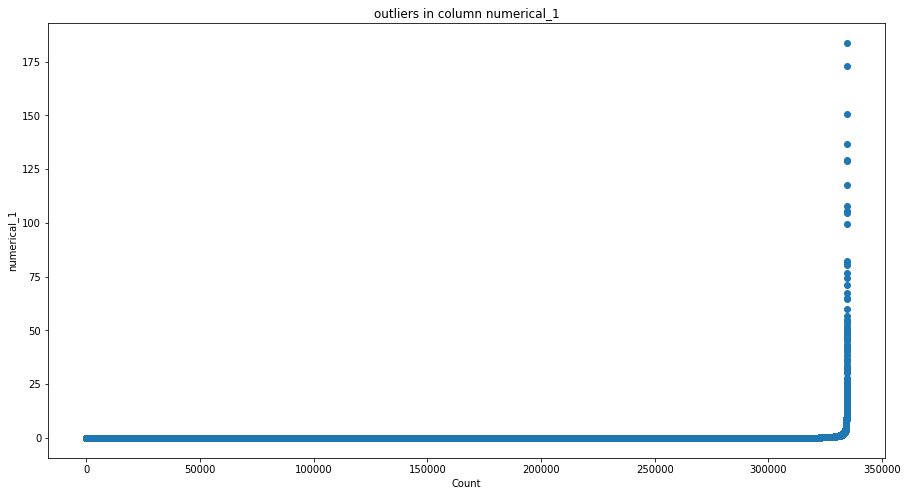

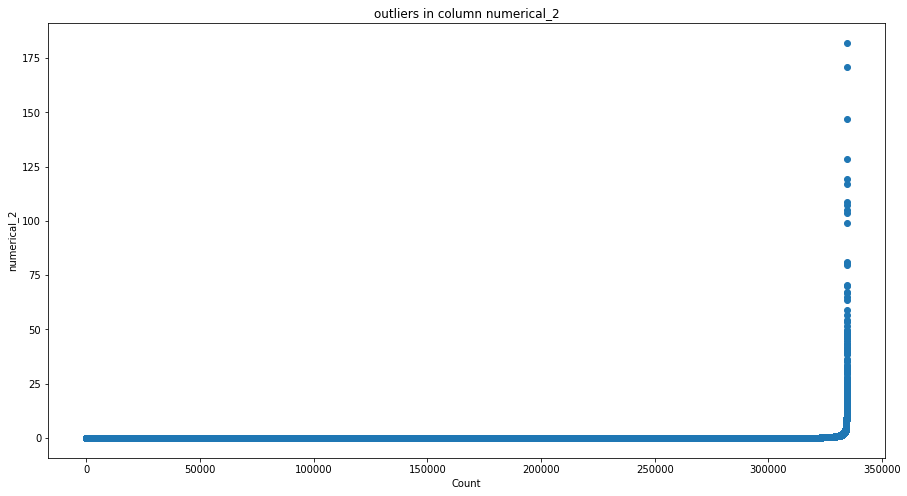

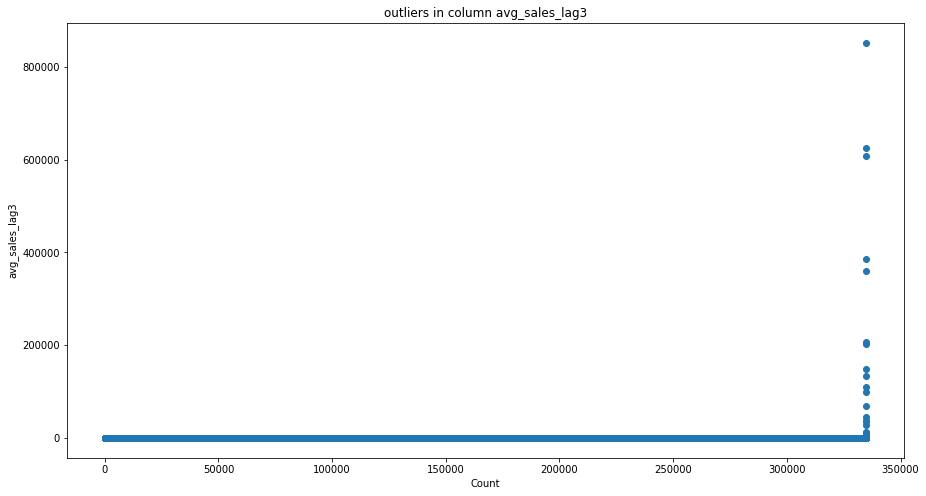

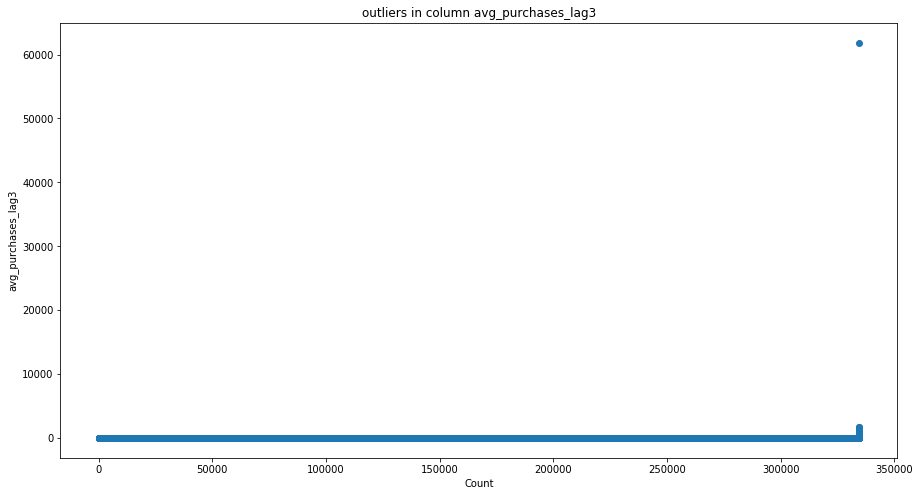

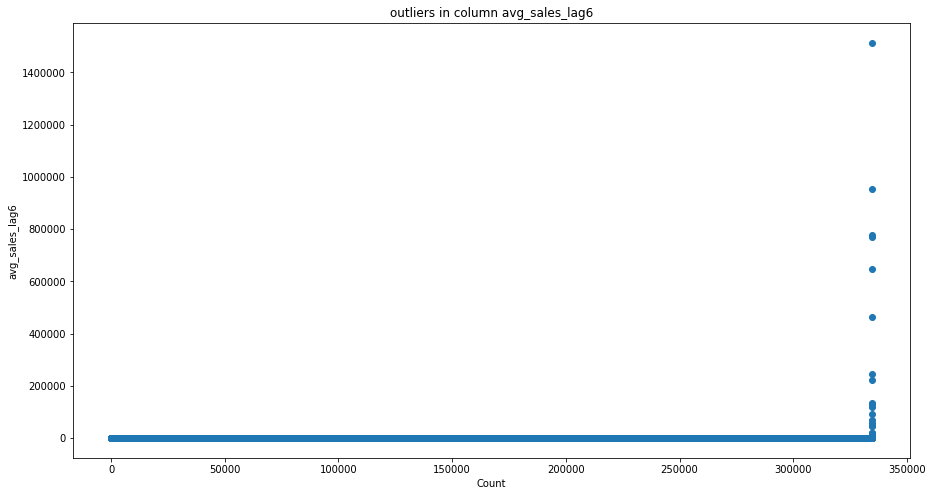

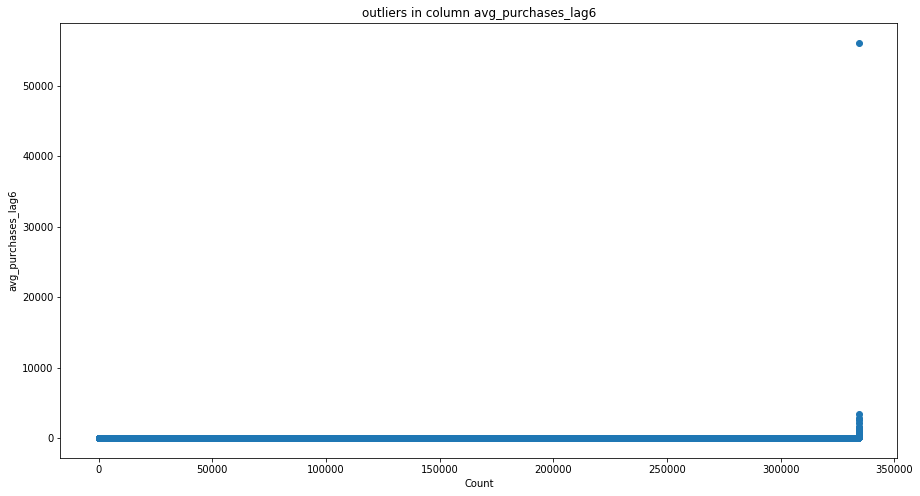

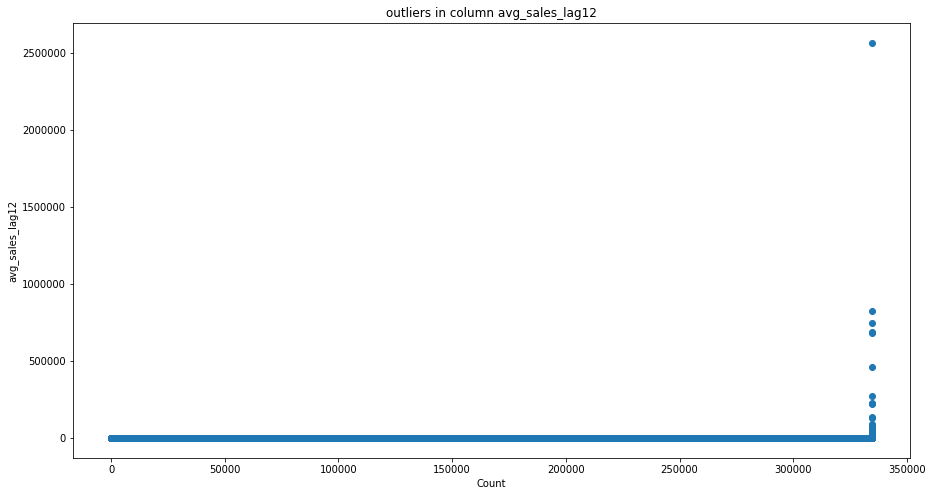

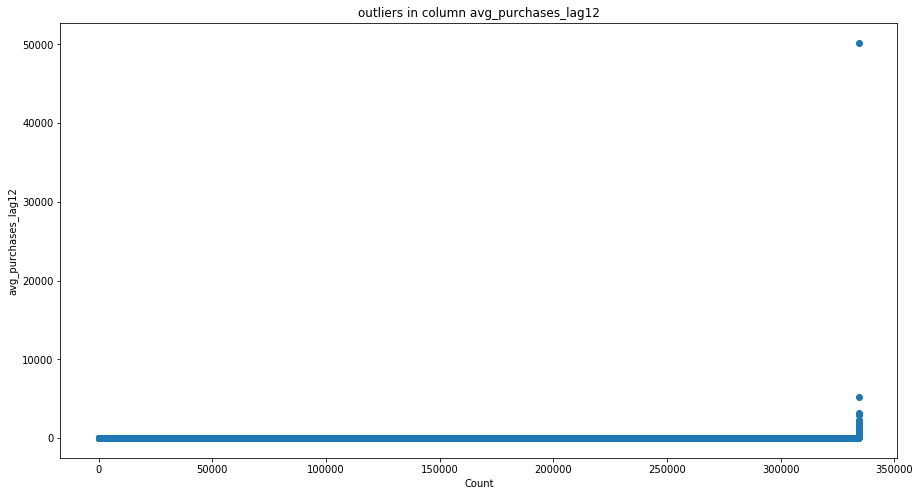

In [33]:
outlierplot(merchDF, outlierColumnMerchDF)

In [34]:
#outliers impute
imputeOutliersThreeSigma(merchDF, outlierColumnMerchDF)
#imputeOutliers(merchDF, ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12'])

### Visualize columns after outlier impute

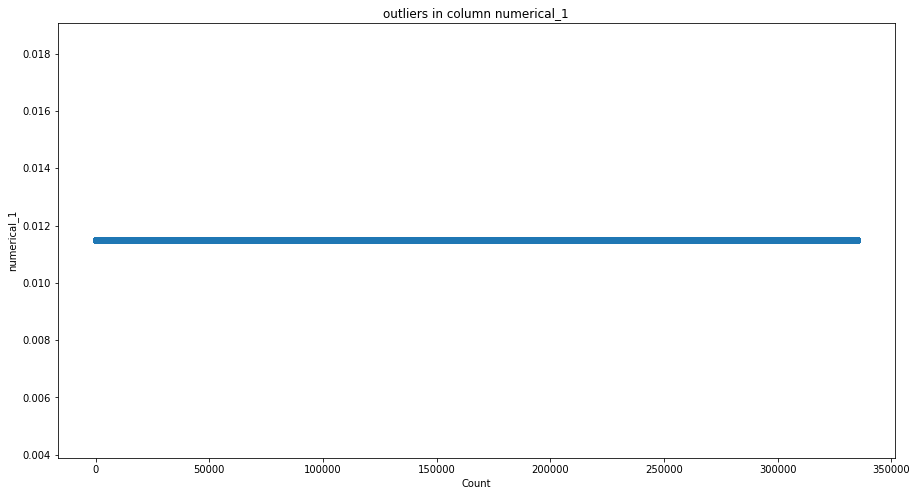

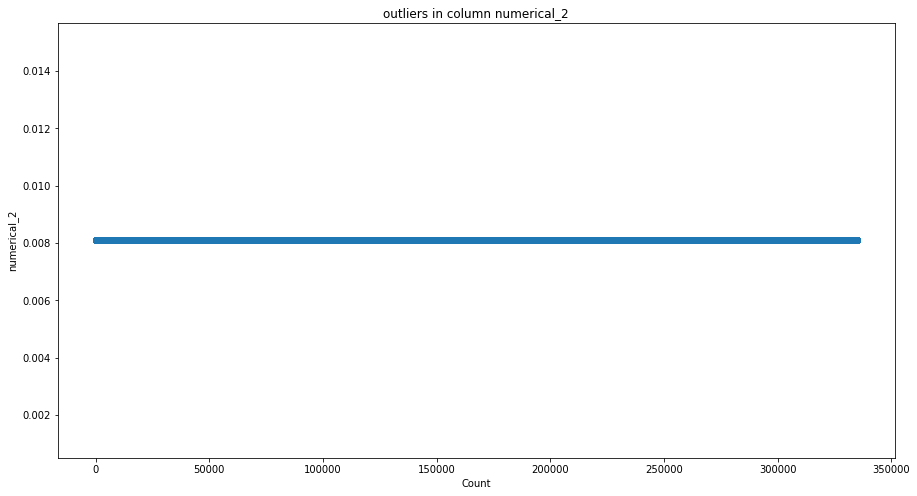

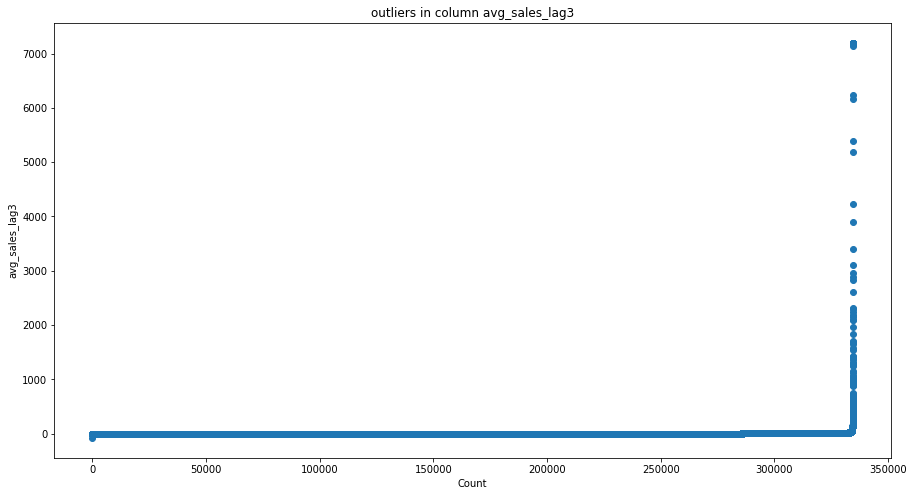

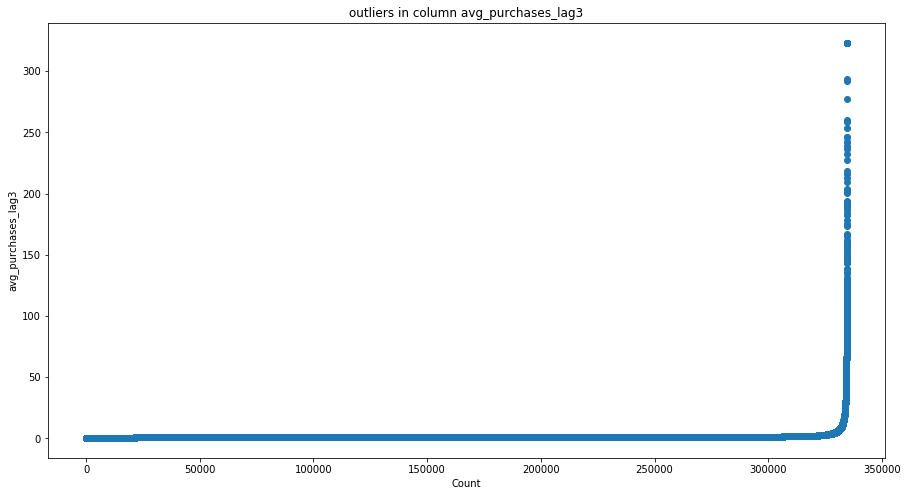

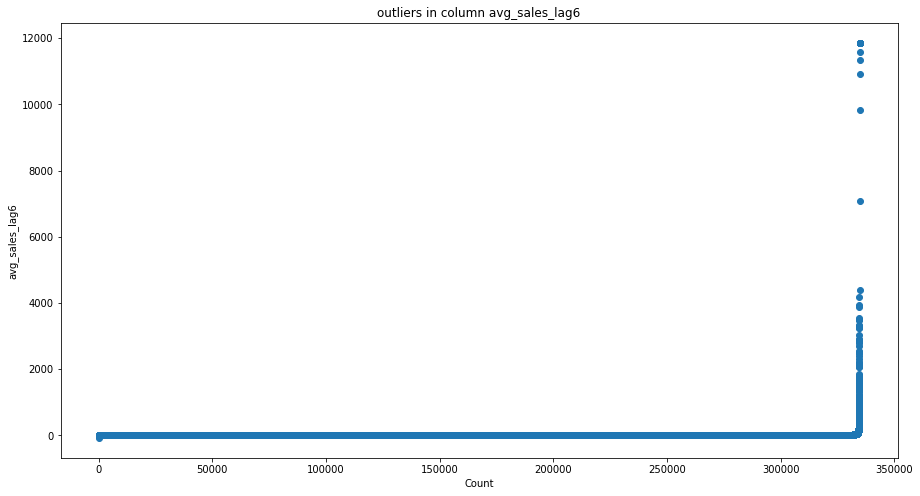

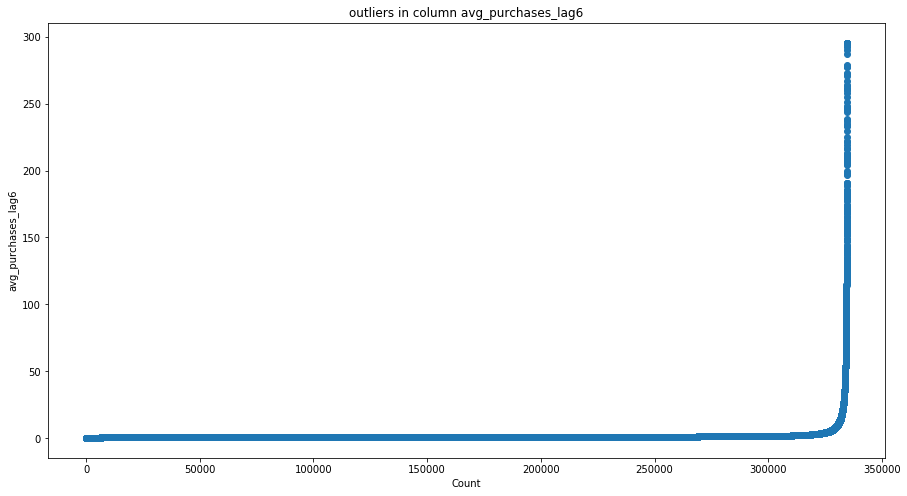

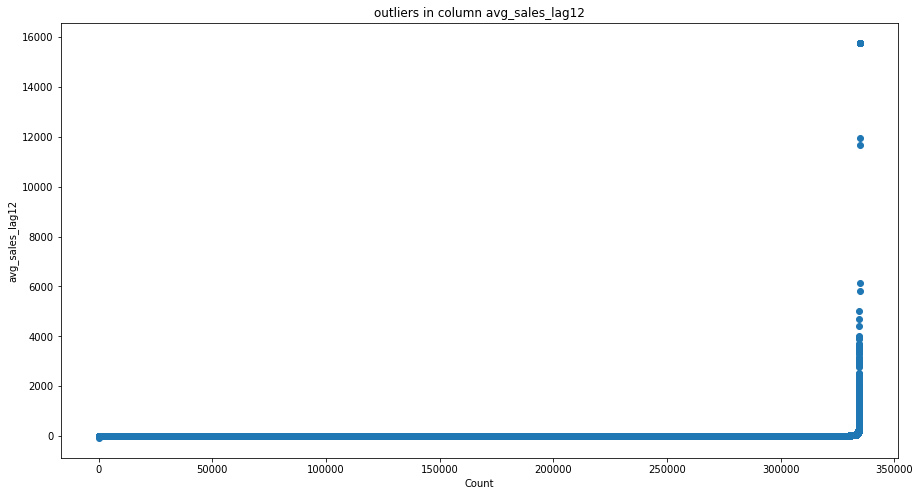

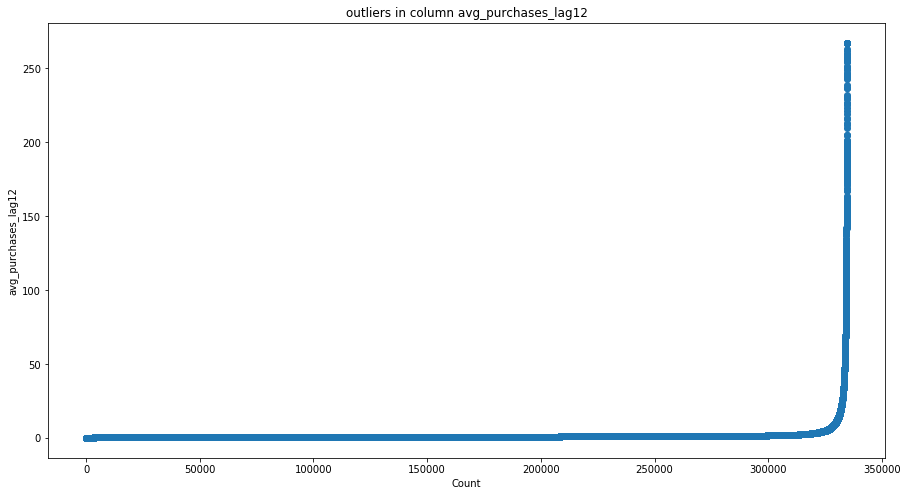

In [35]:
outlierplot(merchDF, outlierColumnMerchDF)

In [48]:
#sns.distplot(merchDF.avg_sales_lag12)

In [ ]:
#outlier avg_sales_lag12
#outlierplot(merchDF, 'avg_sales_lag12', "Average sales lag 12 months column outliers", "avg_sales_lag12")

#outlier avg_sales_lag12
#outlierplot(merchDF, 'avg_sales_lag6', "Average sales lag 6 months column outliers", "avg_sales_lag6")

In [26]:
#imputeOutliers(merchDF, 'avg_sales_lag12')

In [ ]:
#imputeOutliers(merchDF, 'avg_sales_lag12')

In [27]:
#outlier avg_sales_lag12
#outlierplot(merchDF, ['avg_sales_lag12'])

### EDA Merchant data

**Correlation in Merchant Data** 

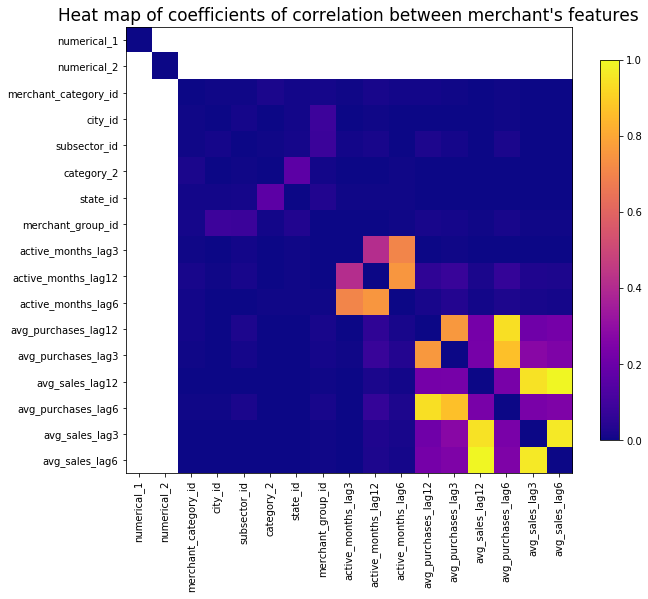

In [47]:
#corelation between merchant data
corelations = np.abs(merchDF.corr())
ordered_cols = (corelations).sum().sort_values().index
np.fill_diagonal(corelations.values, 0)
plt.figure(figsize=[10,10])
plt.imshow(corelations.loc[ordered_cols, ordered_cols], cmap='plasma', vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corelations.shape[0]), list(ordered_cols), rotation=90)
plt.yticks(range(corelations.shape[0]), list(ordered_cols))
plt.title('Heat map of coefficients of correlation between merchant\'s features', fontsize=17)
plt.show()

Findings
1. There is a corelation numerical_1 and numerical_2 feature.
2. There is also correlation between avg_sales and avg_purchases of 3, 6 an 12 month.

**Distribution of Merchant Category ID**

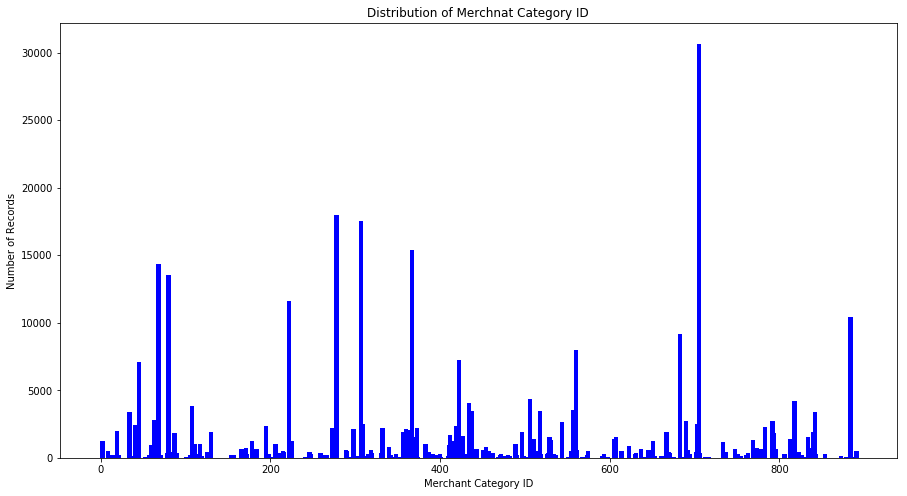

In [49]:
#Distribution of merchant category
drawGraph(merchDF.merchant_category_id, "Merchant Category ID", "Number of Records", "Distribution of Merchnat Category ID", 5.0)

In [50]:
mechCount = merchDF.merchant_category_id.value_counts()
mechCount[mechCount > 30000]

705    30666
Name: merchant_category_id, dtype: int64

In [51]:
mechCountMerchPerc = (mechCount[mechCount > 30000])/len(merchDF.merchant_category_id)*100
mechCountMerchPerc

705    9.162344
Name: merchant_category_id, dtype: float64

**Merchant category ID 705 is the most famous merchant category with 9% sales**

**Distribution of City ID**

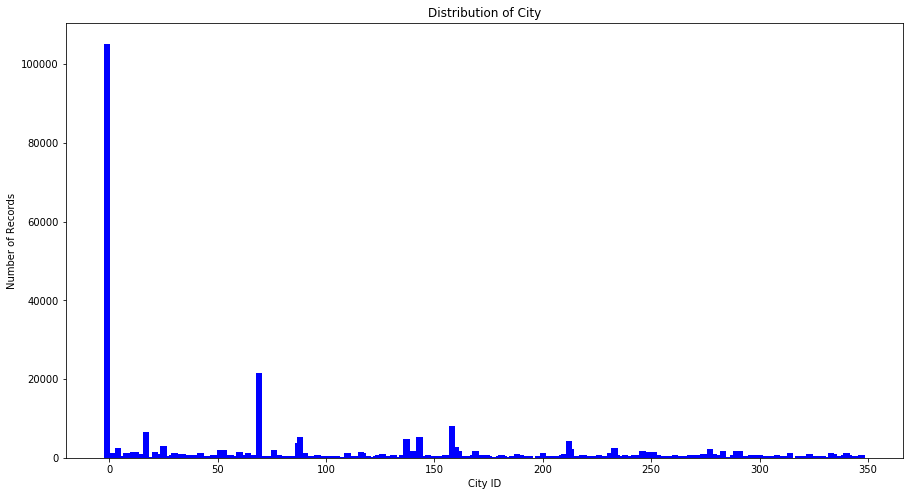

In [52]:
#Distribution of City ID
drawGraph(merchDF.city_id, "City ID", "Number of Records", "Distribution of City", 3.0)

In [53]:
mechCuntCtyId = merchDF.city_id.value_counts()
mechCuntCtyId[mechCuntCtyId > 100000]

-1    105184
Name: city_id, dtype: int64

In [54]:
mechCuntCtyIdPerc = (mechCuntCtyId[mechCuntCtyId > 100000]/len(merchDF.city_id))*100
mechCuntCtyIdPerc

-1    31.426728
Name: city_id, dtype: float64

**City ID -1 has over 100000 transactions and amounts to 31% of transactions**

**Distribution of subsector ID**

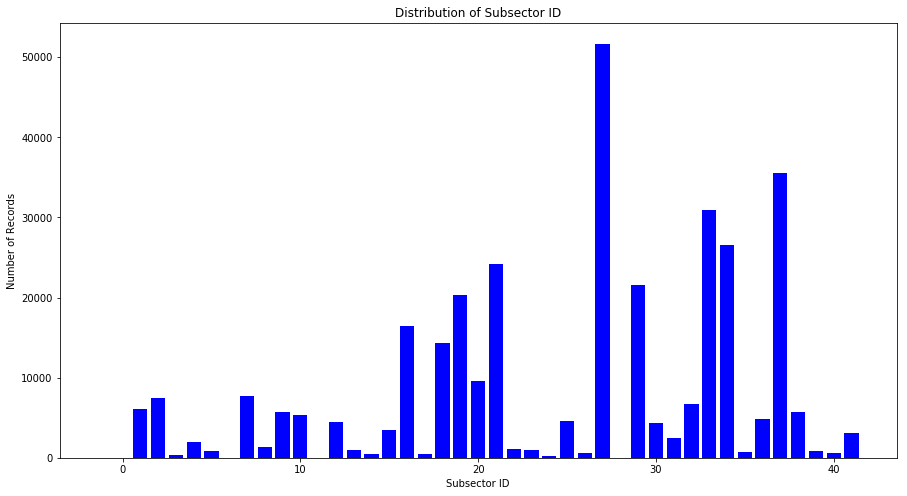

In [55]:
#Distribution of subsector ID
drawGraph(merchDF.subsector_id, "Subsector ID", "Number of Records", "Distribution of Subsector ID", 0.8)

In [56]:
mechCuntSecId = merchDF.subsector_id.value_counts()
mechCuntSecId[mechCuntSecId > 50000]

27    51678
Name: subsector_id, dtype: int64

In [57]:
mechCuntSecIdPerc = (mechCuntSecId[mechCuntSecId > 50000]/len(merchDF.subsector_id))*100
mechCuntSecIdPerc

27    15.44028
Name: subsector_id, dtype: float64

**Subsector ID 27 has over 50000 transactions and amounts to 15% of transactions**

**Percentage of Sales in each category**

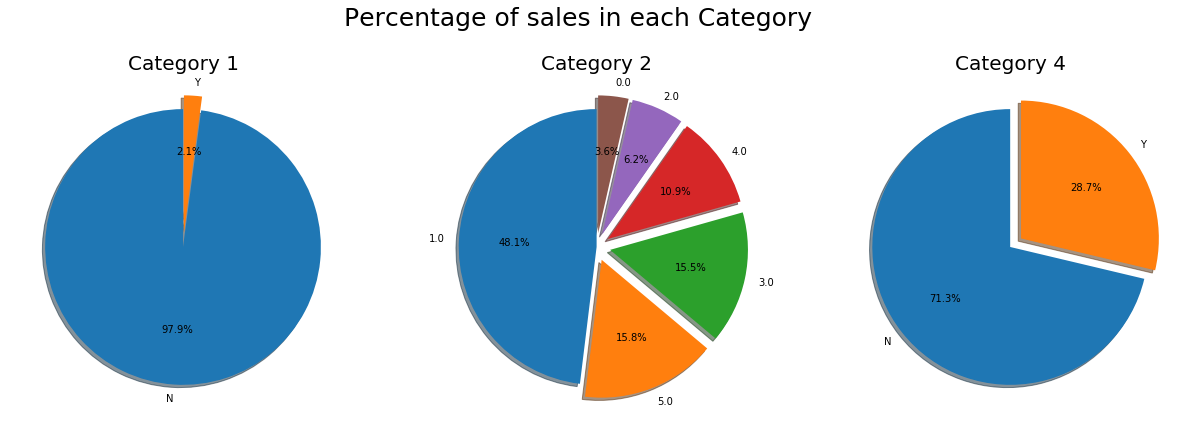

In [58]:
fig1, ax1 = plt.subplots(1, 3, figsize=(21,7))
ax1[0].pie(merchDF.category_1.value_counts(), explode=(0, 0.1), labels=merchDF.category_1.value_counts().index, 
           autopct='%1.1f%%',shadow=True, startangle=90)
ax1[0].set_title("Category 1", fontsize=20)

ax1[1].pie(merchDF.category_2.value_counts(), explode=(0, 0.1, 0.1, 0.1, 0.1, 0.1), 
           labels=merchDF.category_2.value_counts().index, 
           autopct='%1.1f%%',shadow=True, startangle=90)
ax1[1].set_title("Category 2", fontsize=20)

ax1[2].pie(merchDF.category_4.value_counts(), explode=(0, 0.1), labels=merchDF.category_4.value_counts().index, 
           autopct='%1.1f%%', shadow=True, startangle=90)
ax1[2].set_title("Category 4", fontsize=20)

fig1.suptitle("Percentage of sales in each Category", fontsize=25)

plt.show()

**Most Recent Sales and Purchases**

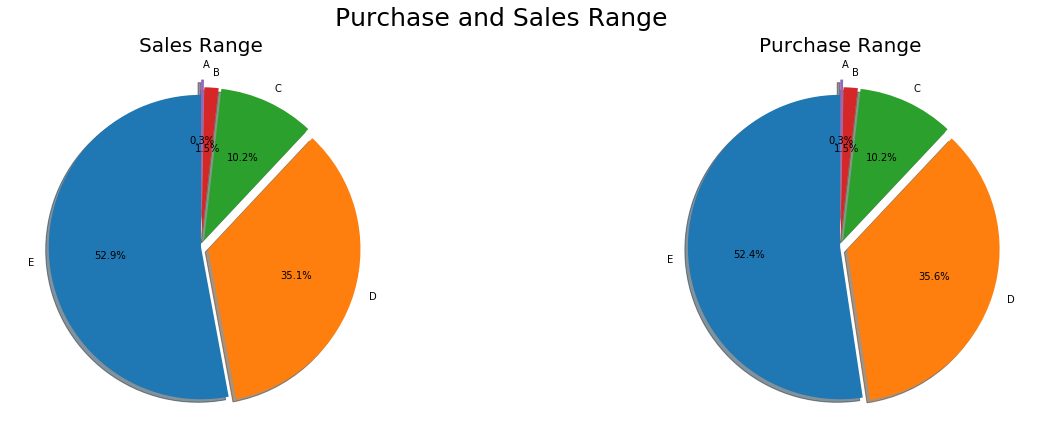

In [59]:
fig1, ax1 = plt.subplots(1, 2, figsize=(21,7))
ax1[0].pie(merchDF.most_recent_sales_range.value_counts(), explode=(0, 0.05, 0.05, 0.05, 0.1),
           labels=merchDF.most_recent_sales_range.value_counts().index, 
           autopct='%1.1f%%',shadow=True, startangle=90)
ax1[0].set_title("Sales Range", fontsize=20)

ax1[1].pie(merchDF.most_recent_purchases_range.value_counts(), explode=(0, 0.05, 0.05, 0.05, 0.1),  
           labels=merchDF.most_recent_purchases_range.value_counts().index, 
           autopct='%1.1f%%',shadow=True, startangle=90)
ax1[1].set_title("Purchase Range", fontsize=20)

fig1.suptitle("Purchase and Sales Range", fontsize=25)

plt.show()

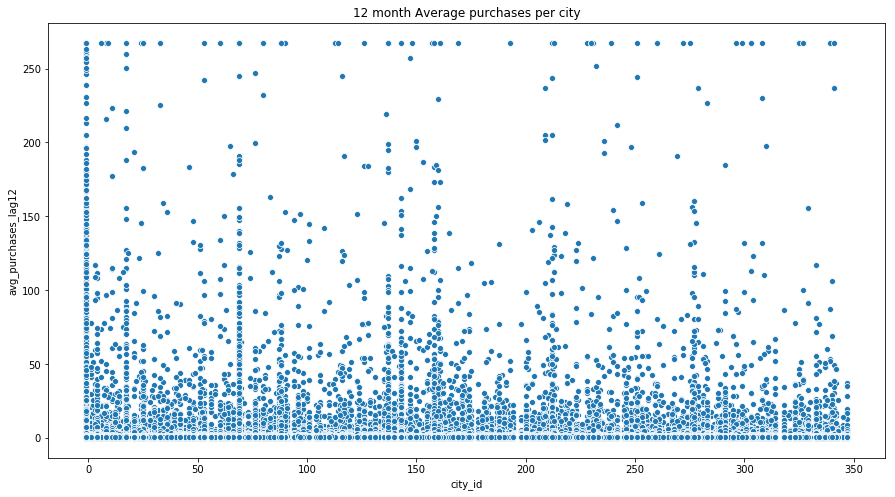

In [60]:
plt.figure(figsize=[15,8])
sns.scatterplot(x=merchDF.city_id, y=merchDF.avg_purchases_lag12)
plt.title("12 month Average purchases per city")
plt.show()

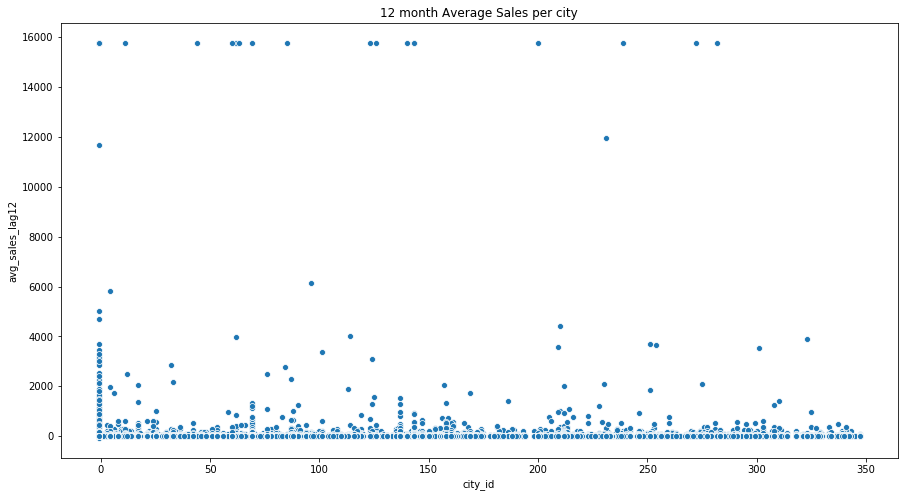

In [61]:
plt.figure(figsize=[15,8])
sns.scatterplot(x=merchDF.city_id, y=merchDF.avg_sales_lag12)
plt.title("12 month Average Sales per city")
plt.show()

**Quantity of active months in a year**

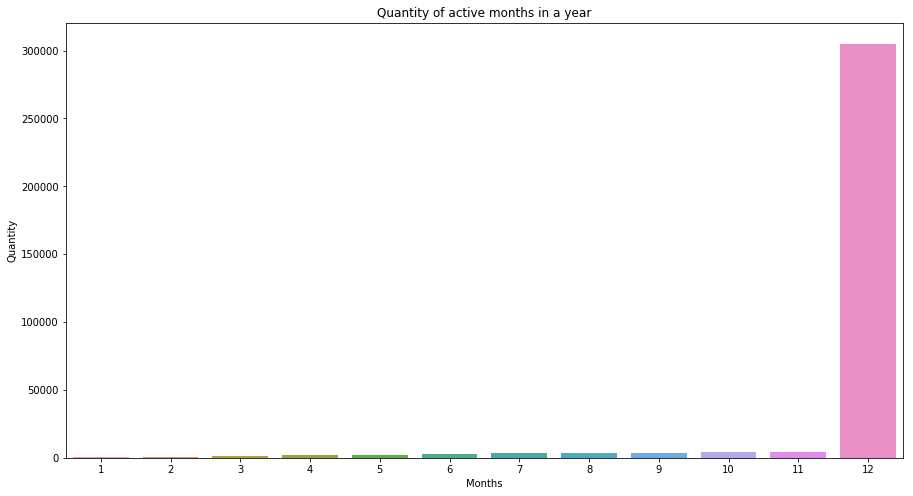

In [63]:
plt.figure(figsize=[15,8])
sns.barplot(x=merchDF.active_months_lag12.value_counts().index, y=merchDF.active_months_lag12.value_counts())
plt.xlabel("Months")
plt.ylabel("Quantity")
plt.title("Quantity of active months in a year")
plt.show()

Most Sales are in the month of December

**Most Recent sales Range**

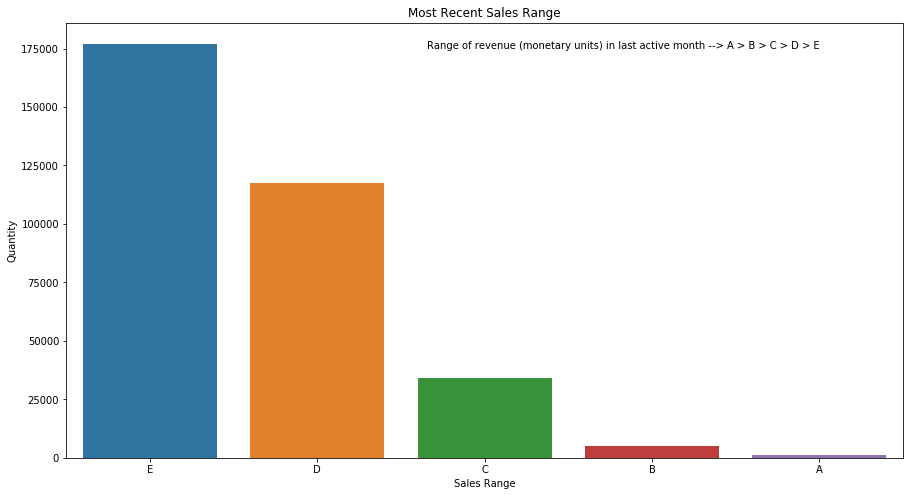

In [64]:
plt.figure(figsize=[15,8])
sns.barplot(x=merchDF.most_recent_sales_range.value_counts().index, y=merchDF.most_recent_sales_range.value_counts())
plt.xlabel("Sales Range")
plt.ylabel("Quantity")
plt.title("Most Recent Sales Range")
plt.text(4,175000,'Range of revenue (monetary units) in last active month --> A > B > C > D > E',horizontalalignment='right')
plt.show()

**Most Recent Purchase Range**

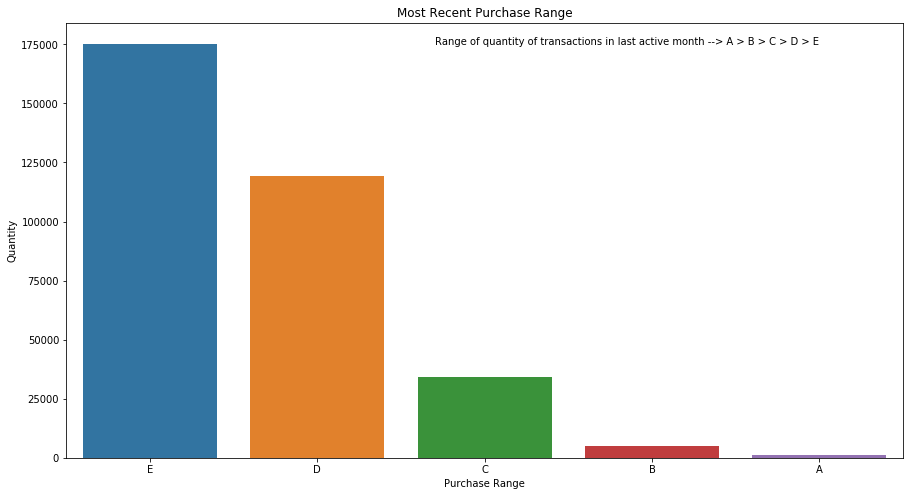

In [65]:
plt.figure(figsize=[15,8])
sns.barplot(x=merchDF.most_recent_purchases_range.value_counts().index, y=merchDF.most_recent_purchases_range.value_counts())
plt.xlabel("Purchase Range")
plt.ylabel("Quantity")
plt.title("Most Recent Purchase Range")
plt.text(4,175000,'Range of quantity of transactions in last active month --> A > B > C > D > E',horizontalalignment='right')
plt.show()

#### Historical Transcations

In [36]:
#read historical transcations data
histDF = reduce_mem_usage(pd.read_csv(histFilePath, parse_dates=['purchase_date'])) # read historical_transactions.csv file to a dataframe

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


In [103]:
histDF.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         29112361 non-null object
card_id                 29112361 non-null object
city_id                 29112361 non-null int16
category_1              29112361 non-null object
installments            29112361 non-null int16
category_3              28934202 non-null object
merchant_category_id    29112361 non-null int16
merchant_id             28973880 non-null object
month_lag               29112361 non-null int8
purchase_amount         29112361 non-null float32
purchase_date           29112361 non-null datetime64[ns]
category_2              26459497 non-null float16
state_id                29112361 non-null int8
subsector_id            29112361 non-null int8
dtypes: datetime64[ns](1), float16(1), float32(1), int16(3), int8(3), object(5)
memory usage: 1.7+ GB


**There are columns have null values and needs to be imputed**

### Data Cleaning

Columns with NaN data are imputed
1. Columns with object datatype are imputed with "other"
3. Columns with int and float datatype are imputed with median

In [ ]:
#purchase_amount is a 16 digit length and, mean and std of purchase_amount return nan. so converting it to float64 
histDF.purchase_amount = histDF.purchase_amount.astype(np.float64())

In [38]:
histDF.category_2.fillna(3, inplace=True)
#histDF.category_2.mean()

In [37]:
# impute columns
imputeNaN(histDF)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05,1.0,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51,1.0,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55,1.0,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56,1.0,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22,1.0,16,37


#### Add datetime features from purchase_date

Following features are created for purchase_date
1. Purchase year
2. Purchase month
3. Purchase day of the week
4. Purchase week of the year
5. Purchase weekend
6. Purchase hour
7. month difference - difference in numbers of months from current date to purchase date

In [39]:
# create features from 'purchase_date'
purchaseDateEng(histDF, 'purchase_date')

### Check following columns for Outlier

Outlier identification is applied for following columns are other columns are either categorical, datetime or ID's
1. installments
2. purchase_amount

In [107]:
outlierColumnHistDF = ['installments', 'purchase_amount']

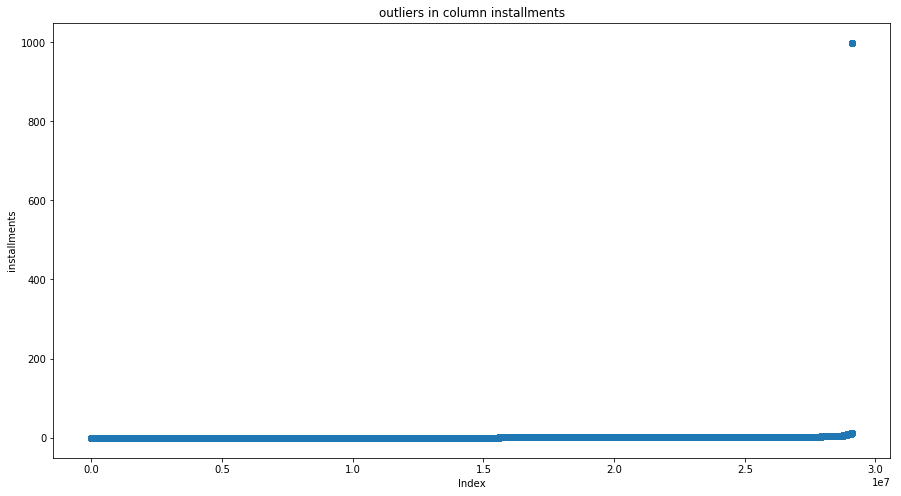

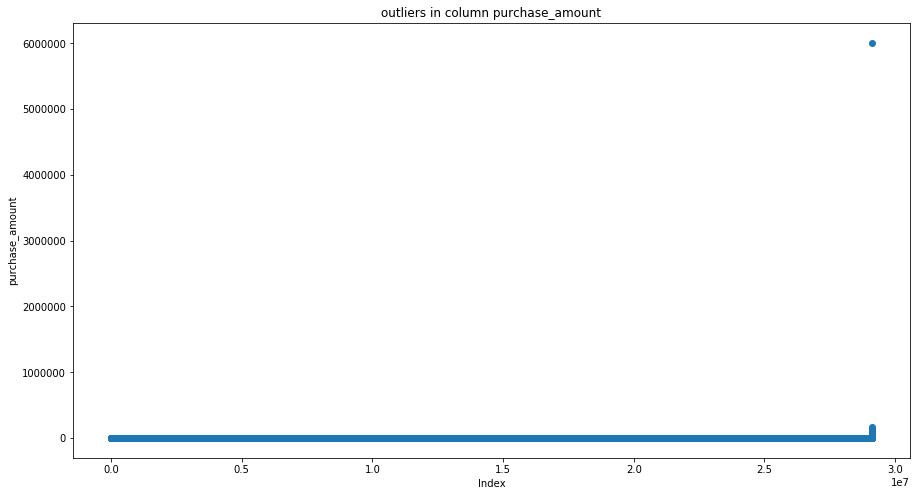

In [108]:
outlierplot(histDF, outlierColumnHistDF)

In [40]:
#outliers impute
imputeOutliersThreeSigma(histDF, ['installments'])
#imputeOutliers(merchDF, ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12'])

In [41]:
#outlierBoundary = np.percentile(histDF['purchase_amount'], [1, 99])
#histDF['purchase_amount'].mask(histDF['purchase_amount'] < outlierBoundary[0] , 
#                                   other = outlierBoundary[0], inplace=True)
#histDF['purchase_amount'].mask(histDF['purchase_amount'] > outlierBoundary[1] , 
#                                   other = outlierBoundary[1], inplace=True)

In [81]:
outlierPercentile(histDF, ['purchase_amount'])

[-0.74324131  1.22084095]


### Visualize columns after outlier impute

In [199]:
outlierplot(histDF, outlierColumnHistDF)

NameError: name 'histDF' is not defined

In [ ]:
#sns.distplot(histDF.installments)
#plt.show()

In [ ]:
#sns.boxplot(y=histDF.installments)
#plt.show()

### EDA Historical Data

**Correlation in Historical Transactions Data** 

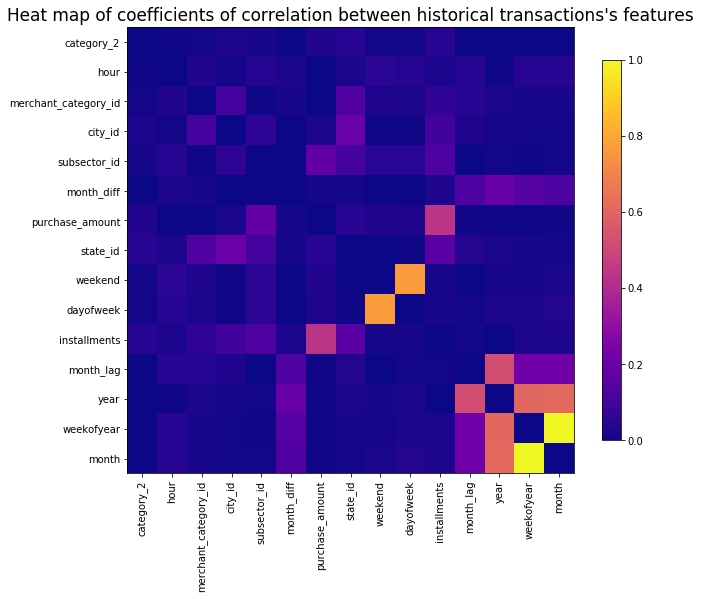

In [112]:
#Correlation between data in Historical Data
corelationsHist = np.abs(histDF.corr())
ordered_cols = (corelationsHist).sum().sort_values().index
np.fill_diagonal(corelationsHist.values, 0)
plt.figure(figsize=[10,10])
plt.imshow(corelationsHist.loc[ordered_cols, ordered_cols], cmap='plasma', vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corelationsHist.shape[0]), list(ordered_cols), rotation=90)
plt.yticks(range(corelationsHist.shape[0]), list(ordered_cols))
plt.title('Heat map of coefficients of correlation between historical transactions\'s features', fontsize=17)
plt.show()

There seems to be no correlation between features.

**Distribution of Subsector ID**

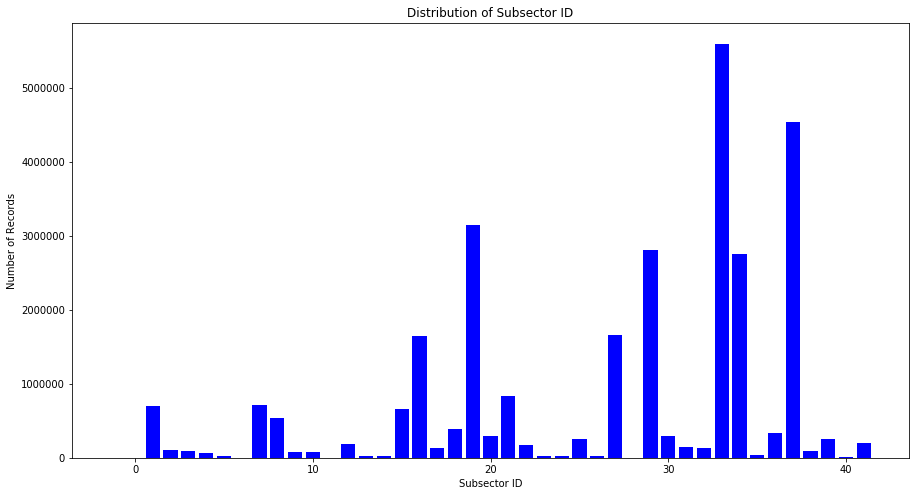

In [113]:
#Distribution of Subsector ID
drawGraph(histDF.subsector_id, "Subsector ID", "Number of Records", "Distribution of Subsector ID", 0.8)

In [114]:
histDFCuntSecId = histDF.subsector_id.value_counts()
histDFCuntSecId[histDFCuntSecId > 5000000]

33    5594146
Name: subsector_id, dtype: int64

In [115]:
histDFCuntSecIdPerc = (histDFCuntSecId[histDFCuntSecId > 5000000]/len(histDF.subsector_id))*100
histDFCuntSecIdPerc

33    19.215707
Name: subsector_id, dtype: float64

**Subsector ID 33 has over 5000000 transactions and amounts to 19% of transactions**

**Distribution of City**

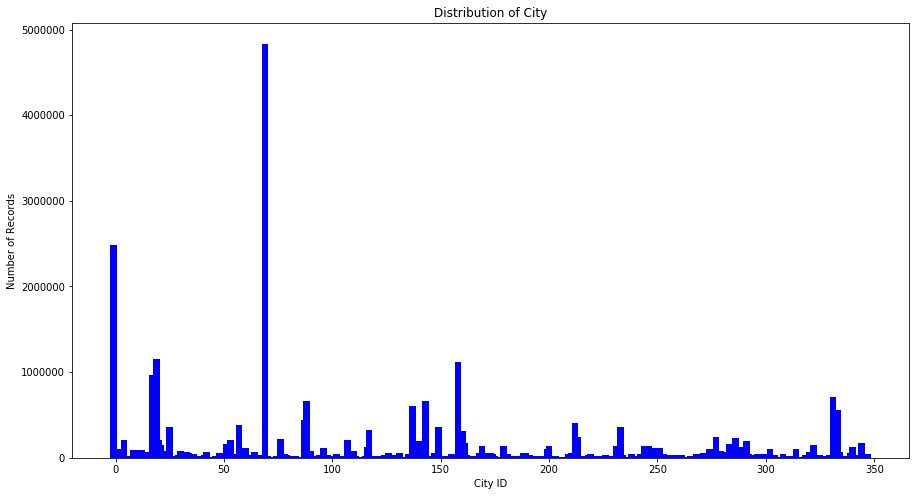

In [116]:
#Distribution of City ID
drawGraph(histDF.city_id, "City ID", "Number of Records", "Distribution of City", 3.0)

In [117]:
histDFCuntcityId = histDF.city_id.value_counts()
histDFCuntcityId[histDFCuntcityId > 4000000]

69    4835441
Name: city_id, dtype: int64

In [118]:
histDFCuntcityIdPerc = (histDFCuntcityId[histDFCuntcityId > 4000000]/len(histDF.city_id))*100
histDFCuntcityIdPerc

69    16.60958
Name: city_id, dtype: float64

**City ID 33 has over 4000000 transactions and amounts to 16% of transactions**

**Percentage of sales in each Category**

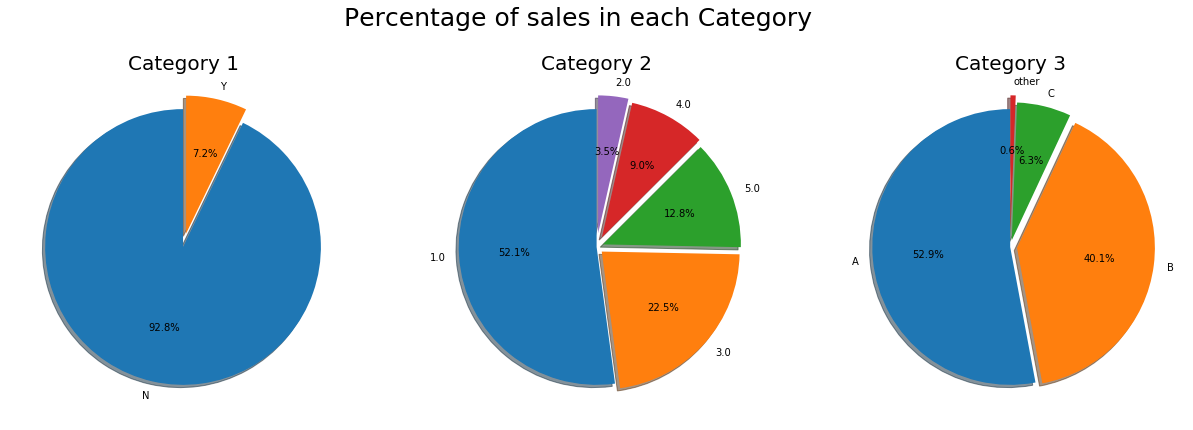

In [119]:
fig1, ax1 = plt.subplots(1, 3, figsize=(21,7))
ax1[0].pie(histDF.category_1.value_counts(), explode=(0, 0.1), labels=histDF.category_1.value_counts().index, 
           autopct='%1.1f%%',shadow=True, startangle=90)
ax1[0].set_title("Category 1", fontsize=20)

ax1[1].pie(histDF.category_2.value_counts(), explode=(0, 0.05, 0.05, 0.08,0.1), 
           labels=histDF.category_2.value_counts().index, 
           autopct='%1.1f%%',shadow=True, startangle=90)
ax1[1].set_title("Category 2", fontsize=20)

ax1[2].pie(histDF.category_3.value_counts(), explode=(0, 0.05, 0.05, 0.1), labels=histDF.category_3.value_counts().index, 
           autopct='%1.1f%%', shadow=True, startangle=90)
ax1[2].set_title("Category 3", fontsize=20)

fig1.suptitle("Percentage of sales in each Category", fontsize=25)

plt.show()

In [120]:
histDF.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,month,dayofweek,weekofyear,weekend,hour,month_diff
0,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,6,25,1,15,13
1,Y,C_ID_4e6213e9bc,88,N,0.0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,5,28,1,12,14
2,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,2,32,0,22,14
3,Y,C_ID_4e6213e9bc,88,N,0.0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,9,5,35,1,10,14
4,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,3,4,10,0,1,14


In [121]:
histDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 21 columns):
authorized_flag         object
card_id                 object
city_id                 int16
category_1              object
installments            float64
category_3              object
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float32
purchase_date           datetime64[ns]
category_2              float16
state_id                int8
subsector_id            int8
year                    int64
month                   int64
dayofweek               int64
weekofyear              int64
weekend                 int32
hour                    int64
month_diff              int64
dtypes: datetime64[ns](1), float16(1), float32(1), float64(1), int16(2), int32(1), int64(6), int8(3), object(5)
memory usage: 3.3+ GB


In [131]:
aggfuncEDAgrp = {'purchase_amount':'sum', 
                 'installments':'sum'}

In [123]:
histGroupbyMonth = groupByAgg(histDF, 'month', aggfuncEDAgrp)

In [124]:
histGroupbyMonth.head(10)

,month,purchase_amount,installments
0,1,-2.390442e+06,2.426069e+06
1,2,-2.198056e+06,2.151337e+06
2,3,-8.741202e+05,8.374975e+05
3,4,-8.654271e+05,8.405888e+05
4,5,-9.224519e+05,9.582989e+05
5,6,-1.007164e+06,1.053272e+06
6,7,-1.207603e+06,1.296034e+06
7,8,-1.319756e+06,1.481560e+06
8,9,-1.440071e+06,1.622023e+06
9,10,-1.506460e+06,1.695869e+06


**Purchase Amount Per Month**

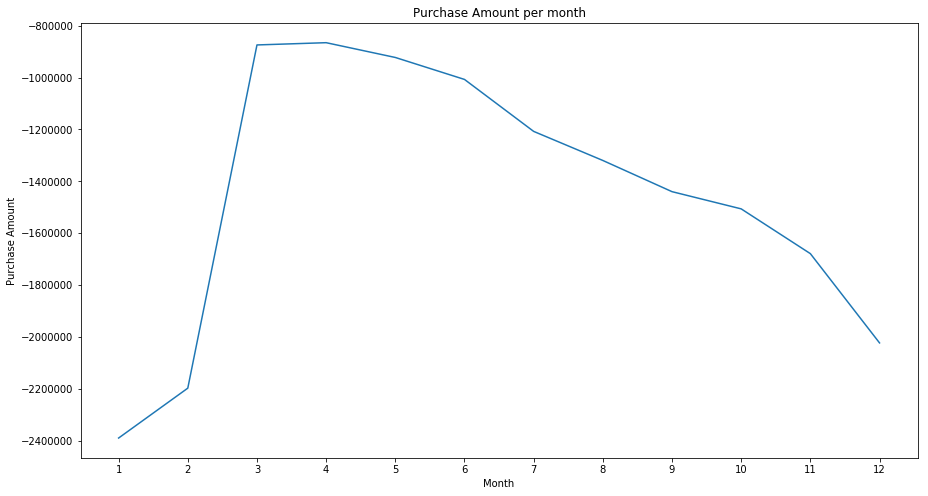

In [125]:
#Purchase amount per month
plt.figure(figsize=[15,8])
sns.lineplot(x=histGroupbyMonth.month, y=histGroupbyMonth.purchase_amount)
plt.xlabel("Month")
plt.ylabel("Purchase Amount")
plt.title("Purchase Amount per month")
plt.xticks(np.arange(1, 13, step=1))
plt.show()

**Installments Per Month**

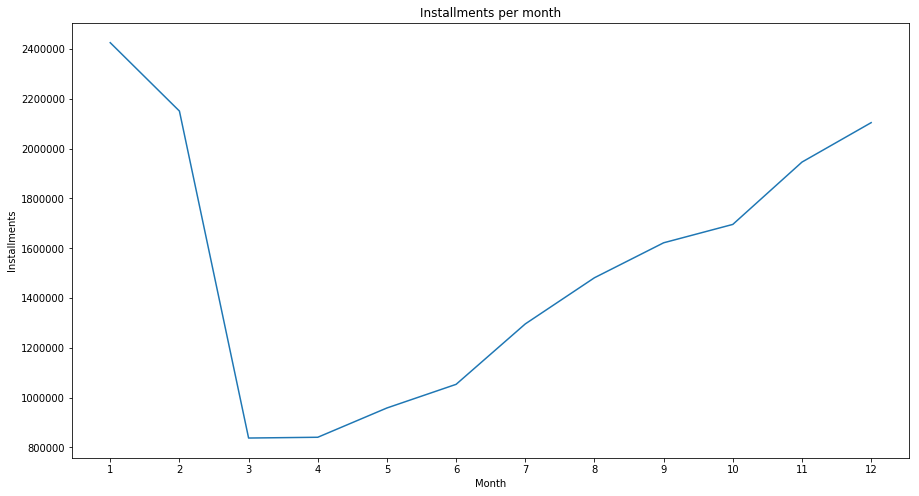

In [126]:
#Installments per month
plt.figure(figsize=[15,8])
sns.lineplot(x=histGroupbyMonth.month, y=histGroupbyMonth.installments)
plt.xlabel("Month")
plt.ylabel("Installments")
plt.title("Installments per month")
plt.xticks(np.arange(1, 13, step=1))
plt.show()

**Purchase Amount and Installments in each Category**

In [127]:
histGroupbycat1 = groupByAgg(histDF, 'category_1', aggfuncEDAgrp)
histGroupbycat2 = groupByAgg(histDF, 'category_2', aggfuncEDAgrp)
histGroupbycat3 = groupByAgg(histDF, 'category_3', aggfuncEDAgrp)

**Purchase Amount in category 1, Category 2 and Category 3**

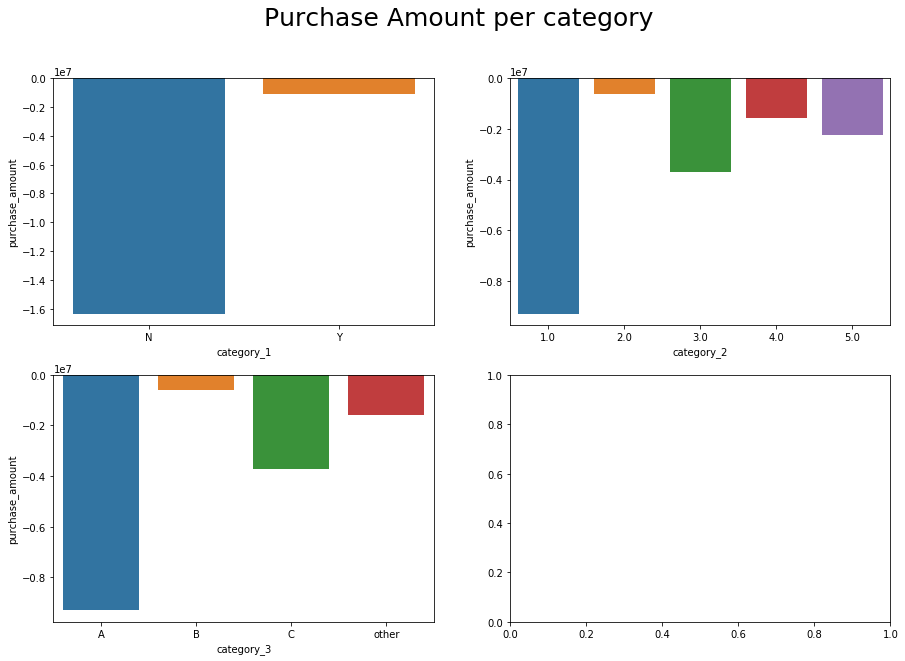

In [128]:
fig, ax = plt.subplots(2, 2, figsize=[15,10])
sns.barplot(x=histGroupbycat1.category_1, y=histGroupbycat1.purchase_amount, ax=ax[0, 0])
sns.barplot(x=histGroupbycat2.category_2, y=histGroupbycat2.purchase_amount, ax=ax[0, 1])
sns.barplot(x=histGroupbycat3.category_3, y=histGroupbycat2.purchase_amount, ax=ax[1, 0])
fig.suptitle("Purchase Amount per category", fontsize=25)
plt.show()

**Installment in category 1, Category 2 and Category 3**

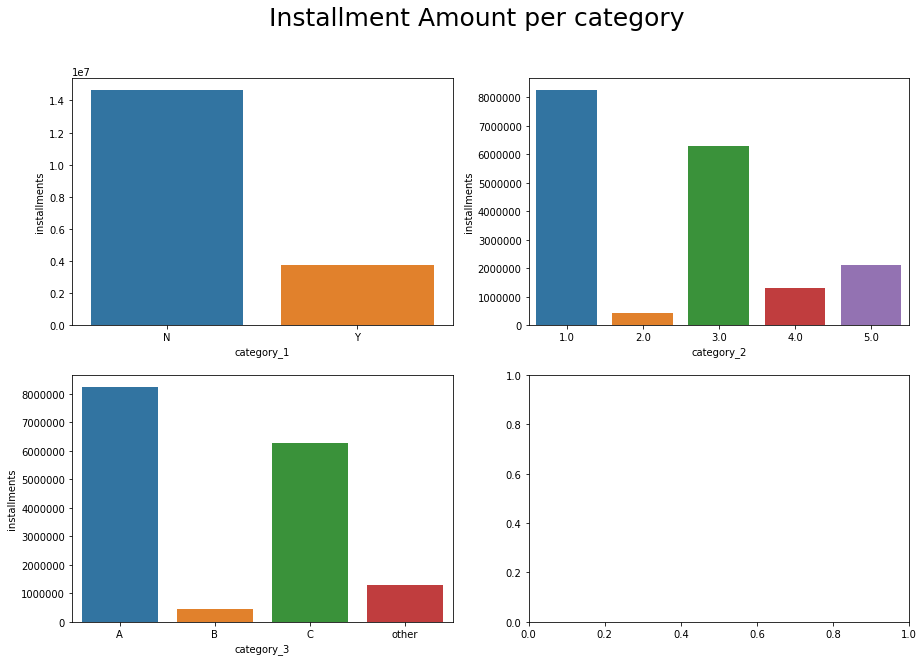

In [129]:
fig, ax = plt.subplots(2, 2, figsize=[15,10])
sns.barplot(x=histGroupbycat1.category_1, y=histGroupbycat1.installments, ax=ax[0, 0])
sns.barplot(x=histGroupbycat2.category_2, y=histGroupbycat2.installments, ax=ax[0, 1])
sns.barplot(x=histGroupbycat3.category_3, y=histGroupbycat2.installments, ax=ax[1, 0])
fig.suptitle("Installment Amount per category", fontsize=25)
plt.show()

In [130]:
histDFGroupbymerchCatID = groupByAgg(histDF, 'merchant_category_id', aggfuncEDAgrp)

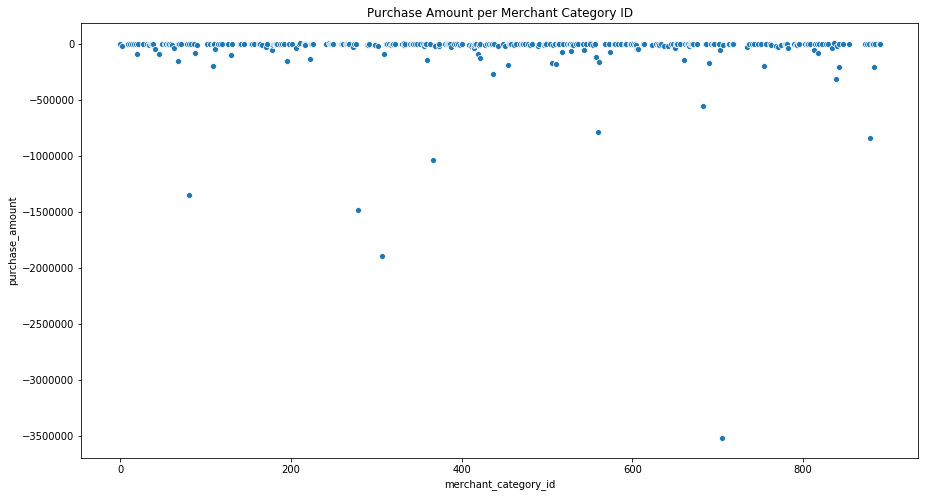

In [131]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x=histDFGroupbymerchCatID.merchant_category_id, y=histDFGroupbymerchCatID.purchase_amount)
plt.title("Purchase Amount per Merchant Category ID")
plt.show()

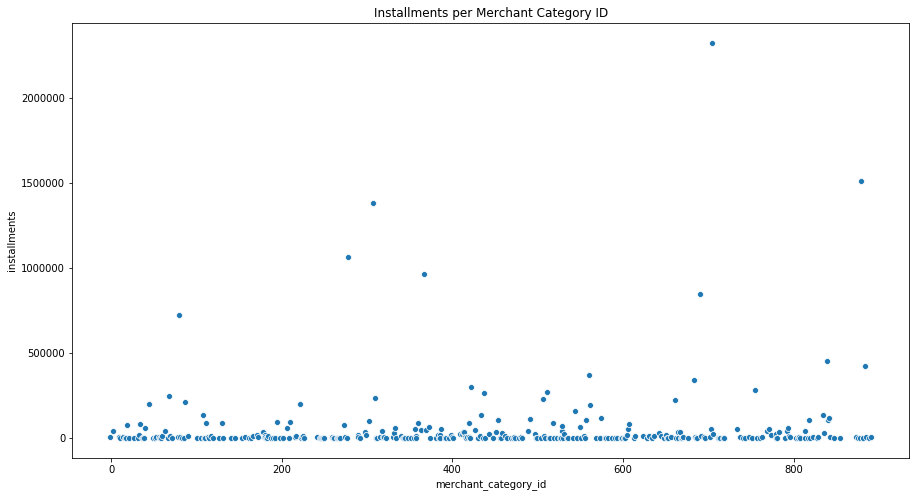

In [132]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x=histDFGroupbymerchCatID.merchant_category_id, y=histDFGroupbymerchCatID.installments)
plt.title("Installments per Merchant Category ID")
plt.show()

**Purchase Amount Per Subsector ID**

In [133]:
histDFGrpBysubsector = groupByAgg(histDF, 'subsector_id', aggfuncEDAgrp)

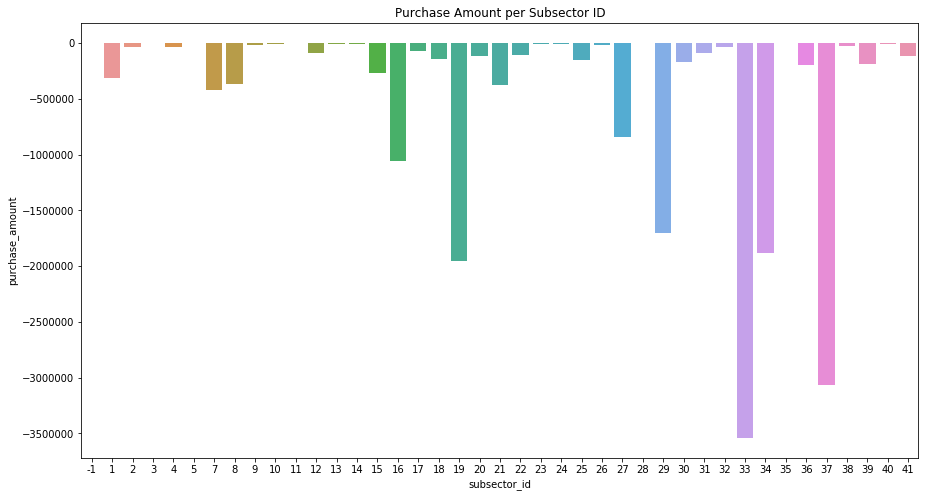

In [134]:
plt.figure(figsize=(15,8))
sns.barplot(x=histDFGrpBysubsector.subsector_id, y=histDFGrpBysubsector.purchase_amount)
plt.title("Purchase Amount per Subsector ID")
plt.show()

**Installments Per Subsector ID**

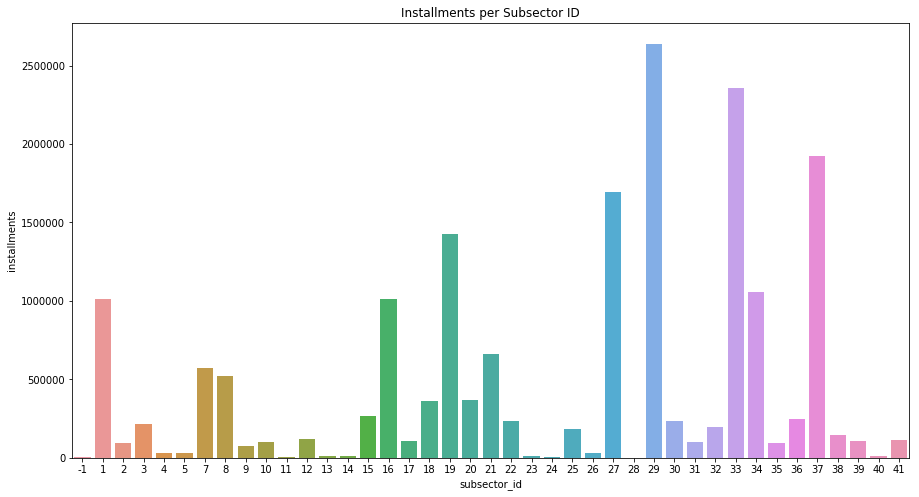

In [135]:
plt.figure(figsize=(15,8))
sns.barplot(x=histDFGrpBysubsector.subsector_id, y=histDFGrpBysubsector.installments)
plt.title("Installments per Subsector ID")
plt.show()

#### New Merchant transcations

In [207]:
# read new merchant transcations data
newMerchDF = reduce_mem_usage(pd.read_csv(newMerchFilePath, parse_dates=['purchase_date'])) # read new_merchant_transactions.csv file to a dataframe

Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [114]:
newMerchDF.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29


In [115]:
newMerchDF.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         1963031 non-null object
card_id                 1963031 non-null object
city_id                 1963031 non-null int16
category_1              1963031 non-null object
installments            1963031 non-null int16
category_3              1907109 non-null object
merchant_category_id    1963031 non-null int16
merchant_id             1936815 non-null object
month_lag               1963031 non-null int8
purchase_amount         1963031 non-null float16
purchase_date           1963031 non-null datetime64[ns]
category_2              1851286 non-null float16
state_id                1963031 non-null int8
subsector_id            1963031 non-null int8
dtypes: datetime64[ns](1), float16(2), int16(3), int8(3), object(5)
memory usage: 114.2+ MB


### Data Cleaning

Columns with NaN data are imputed
1. Columns with object datatype are imputed with "other"
3. Columns with int and float datatype are imputed with median

In [208]:
newMerchDF.category_2.fillna(3.0, inplace=True)

In [209]:
#impute columns
imputeNaN(newMerchDF)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,3.0,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,3.0,-1,29
5,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.632812,2018-04-02 12:53:28,1.0,9,16
6,Y,C_ID_ef55cf8d4b,69,N,1,B,333,M_ID_6d061b5ddc,1,5.265625,2018-03-28 19:50:19,1.0,9,10
7,Y,C_ID_ef55cf8d4b,231,N,1,B,307,M_ID_df1e022f41,2,-0.553711,2018-04-05 08:06:52,1.0,9,19
8,Y,C_ID_ef55cf8d4b,69,N,1,B,278,M_ID_d15eae0468,2,-0.596680,2018-04-07 18:37:40,1.0,9,37
9,Y,C_ID_ef55cf8d4b,69,N,1,B,437,M_ID_5f9bffd028,1,-0.607422,2018-03-17 18:10:41,1.0,9,15


Following features are created for purchase_date
1. Purchase year
2. Purchase month
3. Purchase day of the week
4. Purchase week of the year
5. Purchase weekend
6. Purchase hour
7. month difference - difference in numbers of months from current date to purchase date

In [203]:
purchaseDateEng(newMerchDF, 'purchase_date')

### Check following columns for Outlier

Outlier identification is applied for following columns are other columns are either categorical, datetime or ID's
1. installments
2. purchase_amount

In [216]:
np.mean(newMerchDF.purchase_amount.astype(np.float64))

-0.5509706942429436

In [217]:
newMerchDF.purchase_amount = newMerchDF.purchase_amount.astype(np.float64)

In [218]:
np.mean(newMerchDF.purchase_amount)

-0.5509706942429436

In [127]:
outlierColumnnewMerchDF = ['installments', 'purchase_amount']

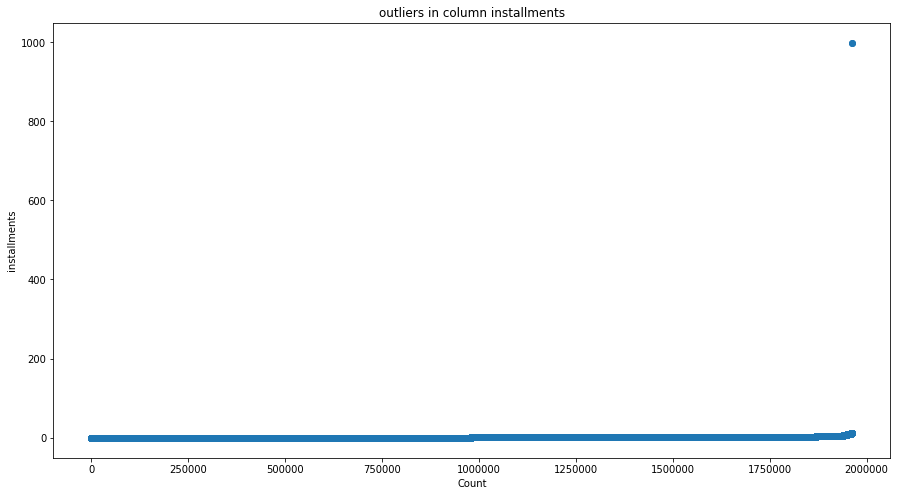

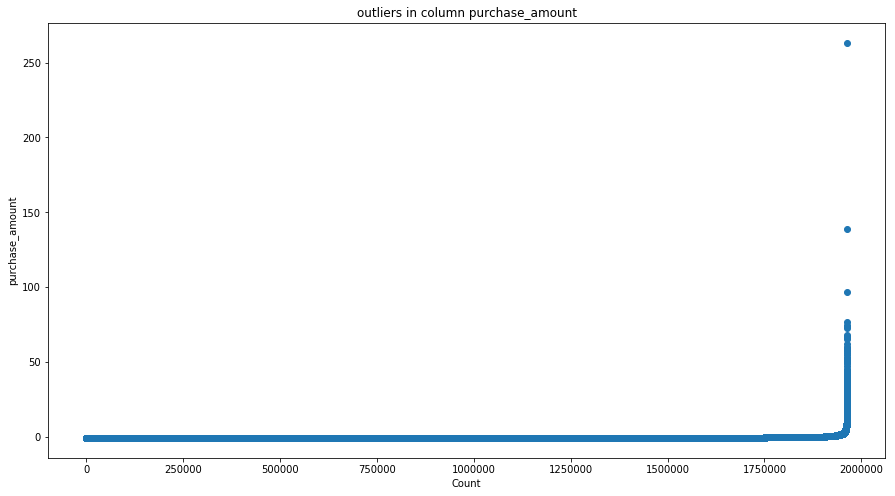

In [109]:
outlierplot(newMerchDF, outlierColumnnewMerchDF)

In [204]:
#outliers impute
imputeOutliersThreeSigma(newMerchDF,  ['installments'])
#imputeOutliers(merchDF, ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12'])

In [205]:
outlierBoundary = np.percentile(newMerchDF['purchase_amount'], [1, 99])
newMerchDF['purchase_amount'].mask(newMerchDF['purchase_amount'] < outlierBoundary[0] , 
                                   other = outlierBoundary[0], inplace=True)
newMerchDF['purchase_amount'].mask(newMerchDF['purchase_amount'] > outlierBoundary[1] , 
                                   other = outlierBoundary[1], inplace=True)

In [198]:
outlierPercentile(newMerchDF, ['purchase_amount'])

[-0.7421875   1.46289062]


### Visualize columns after outlier impute

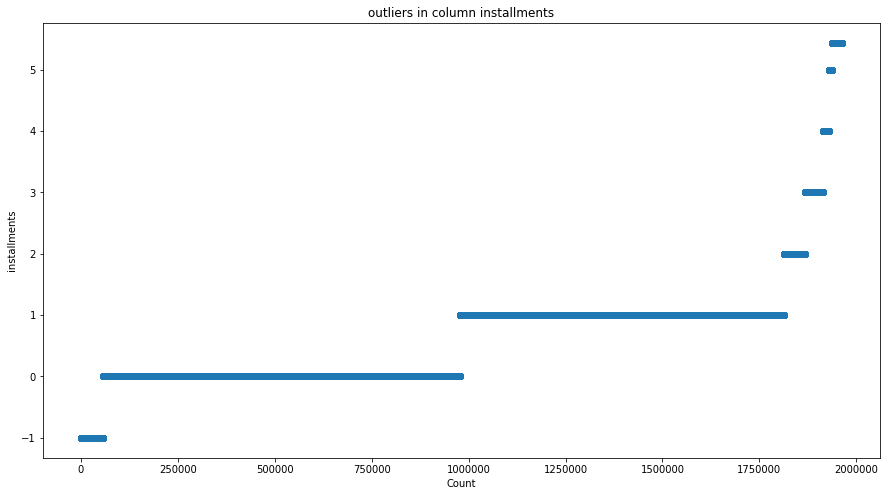

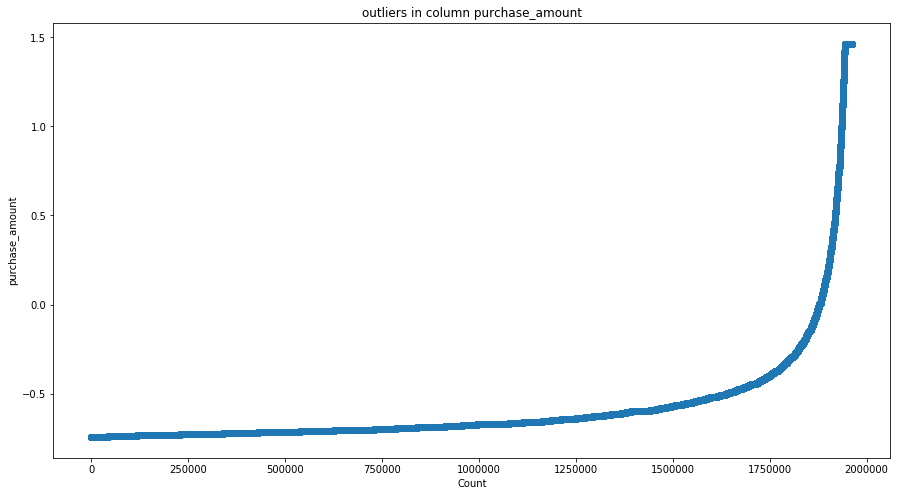

In [112]:
outlierplot(newMerchDF, outlierColumnnewMerchDF)

In [69]:
#imputeOutliers(newMerchDF, 'purchase_amount')

mean nan

Std nan

CutOff nan

plus3sigma nan

minus3sigma nan



In [80]:
#newMerchDF[pd.isnull(newMerchDF.purchase_amount) == True]

In [155]:
np.nanmean(newMerchDF.purchase_amount)

-inf

In [ ]:
#np.sum(newMerchDF.purchase_amount)

In [ ]:
#np.std(newMerchDF.purchase_amount)

In [ ]:
#outlierBoundary = np.percentile(newMerchDF['purchase_amount'], [1, 99])

In [ ]:
#outlierBoundary = np.percentile(newMerchDF['purchase_amount'], [1, 99])
#newMerchDF['purchase_amount'].mask(newMerchDF['purchase_amount'] > outlierBoundary[0] , 
#                                   other = outlierBoundary[0], inplace=True)
#newMerchDF['purchase_amount'].mask(newMerchDF['purchase_amount'] < outlierBoundary[1] , 
#                                   other = outlierBoundary[1], inplace=True)

In [ ]:
#newMerchDF['purchase_amount'].loc[np.logical_and(newMerchDF['purchase_amount'] > outlierBoundary[0],
#                                                 newMerchDF['purchase_amount'] < outlierBoundary[1])]

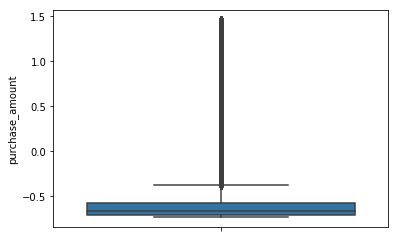

In [156]:
sns.boxplot(y=newMerchDF.purchase_amount)
plt.show()

In [86]:
#newMerchDF[newMerchDF.purchase_amount.isin([-np.inf]) == True]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,month,dayofweek,weekofyear,weekend,hour,month_diff


In [135]:
#import re
#regexp = re.compile('[-~`!@#$%^&*()_=+\[\]{}\\|;:\'\",.<>/?]+')

In [ ]:
#newMerchDF.purchase_amount.filter(regex = regexp)

In [ ]:
#newMerchDF.purchase_amount.apply('sum')

In [ ]:
#np.nanmean(newMerchDF.purchase_amount)

In [163]:
s1 = newMerchDF.purchase_amount.dtype

In [170]:
int(len(newMerchDF.purchase_amount)/2)

981515

In [174]:
newMerchDF.purchase_amount.iloc[(981515-3):981515]

981512   -0.643066
981513   -0.740723
981514   -0.709473
Name: purchase_amount, dtype: float16

In [191]:
for val in range(981515):
    if val == np.inf:
        print(val)

In [190]:
np.nanmean(newMerchDF.purchase_amount.iloc[0:120000])

-inf

In [157]:
newMerchDF.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id,year,month,dayofweek,weekofyear,weekend,hour,month_diff
count,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1963031.0,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06
mean,1.343867e+02,6.449773e-01,4.309701e+02,1.476515e+00,NaN,NaN,1.088067e+01,2.597624e+01,2.017845e+03,4.136058e+00,3.129327e+00,1.608572e+01,3.074383e-01,1.362867e+01,1.464557e+01
std,1.015152e+02,9.858801e-01,2.463385e+02,4.994483e-01,0.000000e+00,0.0,6.038542e+00,1.012908e+01,3.615223e-01,2.445818e+00,1.927728e+00,1.068645e+01,4.614327e-01,4.746415e+00,2.563734e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-7.421875e-01,1.0,-1.000000e+00,-1.000000e+00,2.017000e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01
25%,6.900000e+01,0.000000e+00,2.780000e+02,1.000000e+00,-7.167969e-01,1.0,9.000000e+00,1.900000e+01,2.018000e+03,3.000000e+00,1.000000e+00,1.100000e+01,0.000000e+00,1.000000e+01,1.300000e+01
50%,1.100000e+02,1.000000e+00,3.670000e+02,1.000000e+00,-6.748047e-01,1.0,9.000000e+00,2.900000e+01,2.018000e+03,3.000000e+00,3.000000e+00,1.300000e+01,0.000000e+00,1.400000e+01,1.400000e+01
75%,2.120000e+02,1.000000e+00,6.830000e+02,2.000000e+00,-5.815430e-01,3.0,1.500000e+01,3.400000e+01,2.018000e+03,4.000000e+00,5.000000e+00,1.600000e+01,1.000000e+00,1.700000e+01,1.500000e+01
max,3.470000e+02,5.435170e+00,8.910000e+02,2.000000e+00,1.462891e+00,5.0,2.400000e+01,4.100000e+01,2.018000e+03,1.200000e+01,6.000000e+00,5.200000e+01,1.000000e+00,2.300000e+01,2.600000e+01


### EDA Historical Data

**Correlation of New Merchant Transactions**

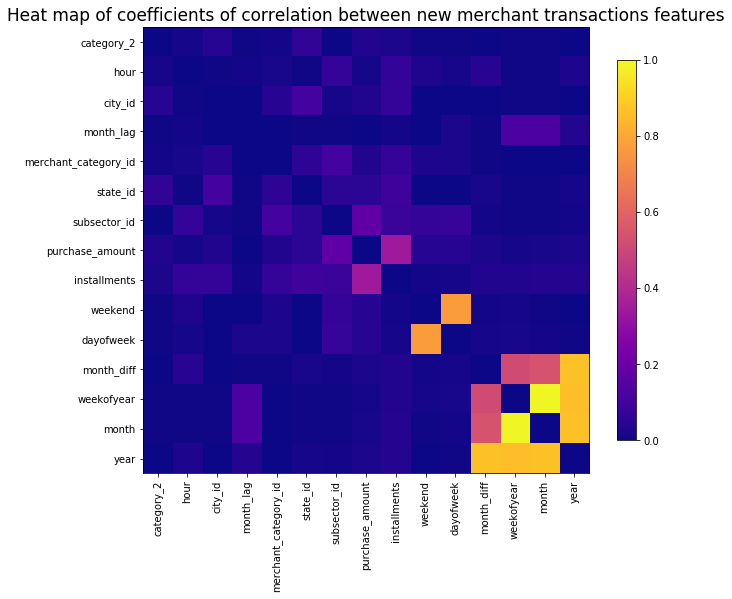

In [148]:
#corelation between data in new merchants column
corelationsnewMerch = np.abs(newMerchDF.corr())
ordered_cols = (corelationsnewMerch).sum().sort_values().index
np.fill_diagonal(corelationsnewMerch.values, 0)
plt.figure(figsize=[10,10])
plt.imshow(corelationsnewMerch.loc[ordered_cols, ordered_cols], cmap='plasma', vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corelationsnewMerch.shape[0]), list(ordered_cols), rotation=90)
plt.yticks(range(corelationsnewMerch.shape[0]), list(ordered_cols))
plt.title('Heat map of coefficients of correlation between new merchant transactions features', fontsize=17)
plt.show()

There is a correlation between installments and purchase_amount.

**Distribution of Subsector ID**

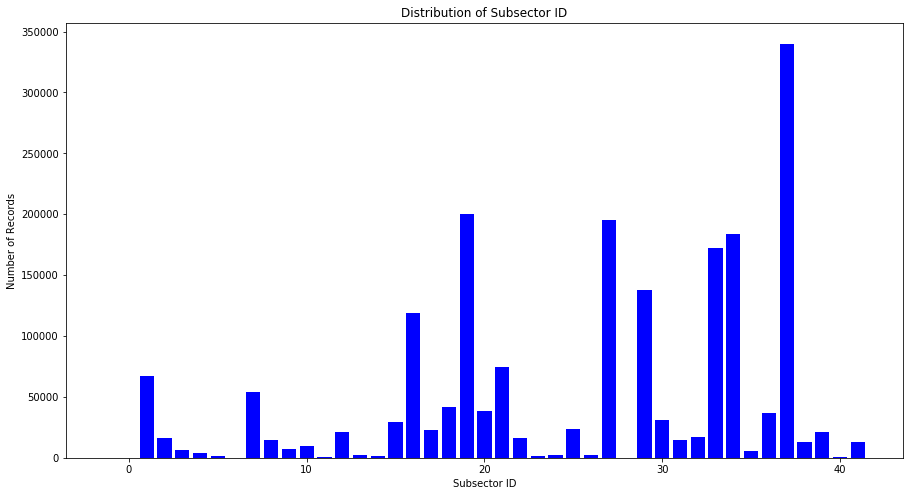

In [149]:
drawGraph(newMerchDF.subsector_id, "Subsector ID", "Number of Records", "Distribution of Subsector ID", 0.8)

In [150]:
newMerchDFCuntSecId = newMerchDF.subsector_id.value_counts()
newMerchDFCuntSecId[newMerchDFCuntSecId > 300000]

37    340053
Name: subsector_id, dtype: int64

In [151]:
newMerchDFCuntSecIdPerc = (newMerchDFCuntSecId[newMerchDFCuntSecId > 300000]/len(newMerchDF.subsector_id))*100
newMerchDFCuntSecIdPerc

37    17.322854
Name: subsector_id, dtype: float64

**Subsector ID 37 has over 340053 transactions and amounts to 17% of transactions**

**Distribution of City**

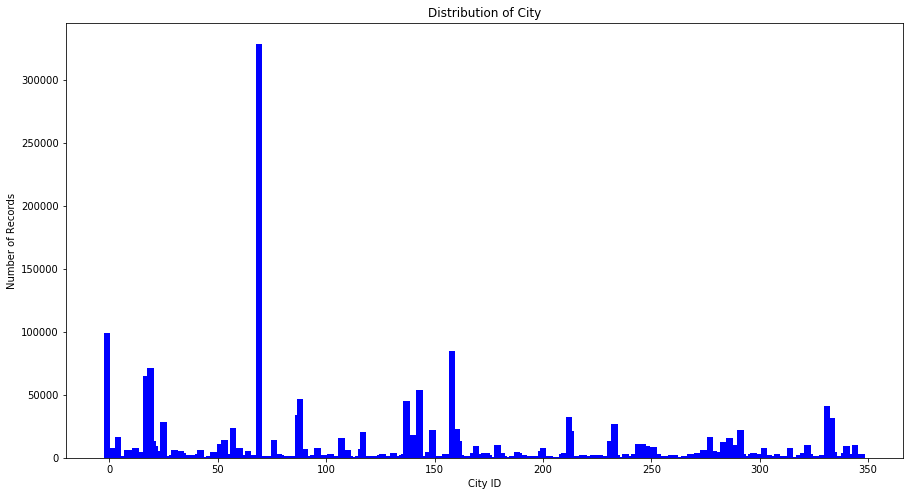

In [152]:
drawGraph(newMerchDF.city_id, "City ID", "Number of Records", "Distribution of City", 3.0)

In [153]:
newMerchDFCuntCityId = newMerchDF.city_id.value_counts()
newMerchDFCuntCityId[newMerchDFCuntCityId > 300000]

69    328916
Name: city_id, dtype: int64

In [154]:
newMerchDFCuntCityIdPerc = (newMerchDFCuntCityId[newMerchDFCuntCityId > 300000]/len(newMerchDF.city_id))*100
newMerchDFCuntCityIdPerc

69    16.755517
Name: city_id, dtype: float64

**City ID 69 has 328916 transactions and amounts to 17% of transactions**

**Percentage of sales in each Category**

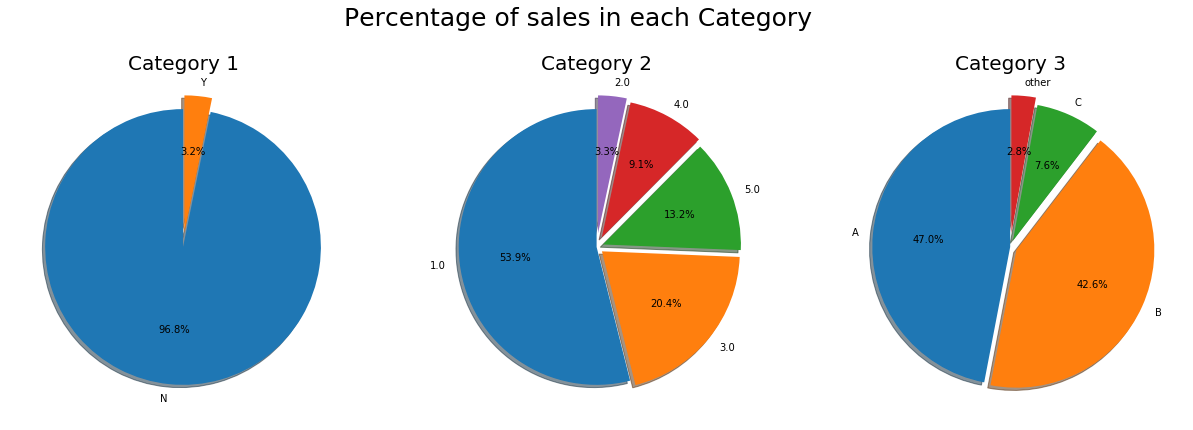

In [155]:
fig1, ax1 = plt.subplots(1, 3, figsize=(21,7))
ax1[0].pie(newMerchDF.category_1.value_counts(), explode=(0, 0.1), labels=newMerchDF.category_1.value_counts().index, 
           autopct='%1.1f%%',shadow=True, startangle=90)
ax1[0].set_title("Category 1", fontsize=20)

ax1[1].pie(newMerchDF.category_2.value_counts(), explode=(0, 0.05, 0.05, 0.08,0.1), 
           labels=newMerchDF.category_2.value_counts().index, 
           autopct='%1.1f%%',shadow=True, startangle=90)
ax1[1].set_title("Category 2", fontsize=20)

ax1[2].pie(newMerchDF.category_3.value_counts(), explode=(0, 0.05, 0.05, 0.1), labels=newMerchDF.category_3.value_counts().index, 
           autopct='%1.1f%%', shadow=True, startangle=90)
ax1[2].set_title("Category 3", fontsize=20)

fig1.suptitle("Percentage of sales in each Category", fontsize=25)

plt.show()

**Purchase Amount per month**

In [156]:
newMerchDFGroupbyMonth = groupByAgg(newMerchDF, 'month', aggfuncEDAgrp)

In [157]:
newMerchDFGroupbyMonth.head(10)

,month,purchase_amount,installments
0,1,-4.819200e+04,57102.147421
1,2,-6.307200e+04,81096.604451
2,3,-inf,537575.089396
3,4,-inf,427913.301027
4,5,-1.260800e+04,10754.941643
5,6,-1.414400e+04,12365.227702
6,7,-1.752000e+04,16029.282805
7,8,-1.776000e+04,17296.689611
8,9,-1.980800e+04,18962.744714
9,10,-2.257600e+04,22114.826557


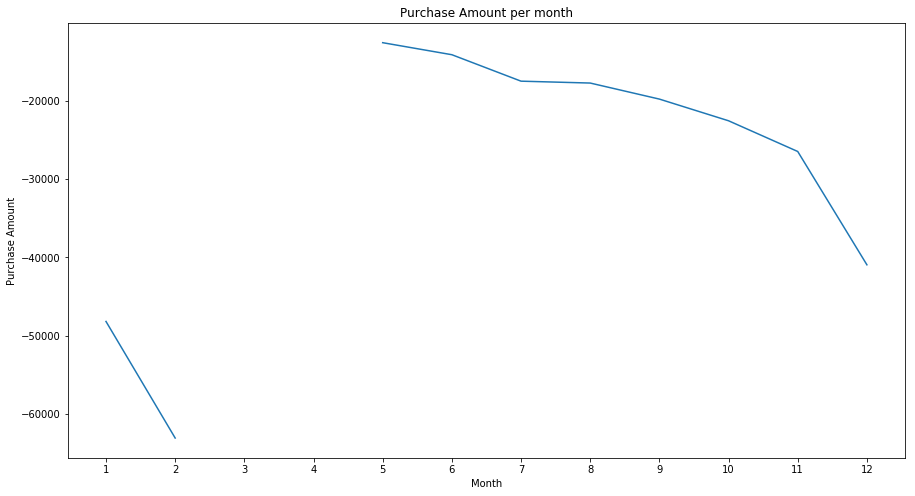

In [158]:
plt.figure(figsize=[15,8])
sns.lineplot(x=newMerchDFGroupbyMonth.month, y=newMerchDFGroupbyMonth.purchase_amount)
plt.xlabel("Month")
plt.ylabel("Purchase Amount")
plt.title("Purchase Amount per month")
plt.xticks(np.arange(1, 13, step=1))
plt.show()

**Installments per month**

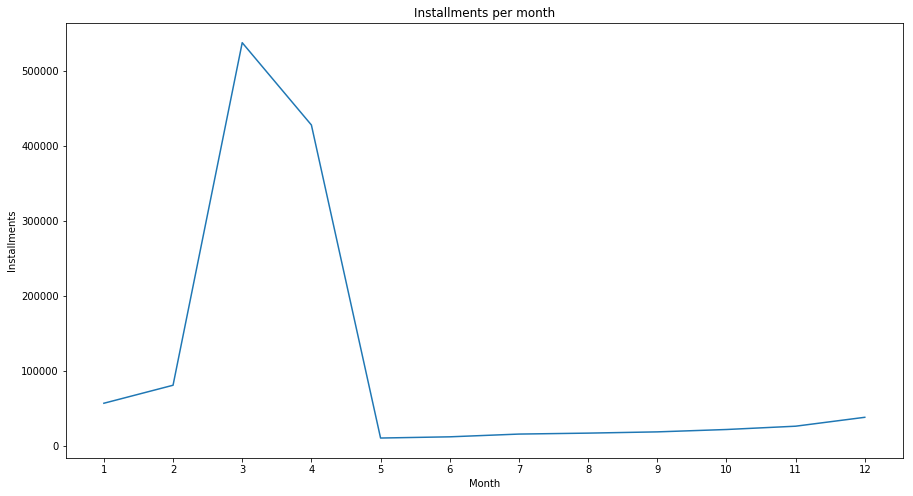

In [159]:
plt.figure(figsize=[15,8])
sns.lineplot(x=newMerchDFGroupbyMonth.month, y=newMerchDFGroupbyMonth.installments)
plt.xlabel("Month")
plt.ylabel("Installments")
plt.title("Installments per month")
plt.xticks(np.arange(1, 13, step=1))
plt.show()

**Purchase Amount and Installments in each Category**

In [132]:
newMerchDFGroupbycat1 = groupByAgg(newMerchDF, 'category_1', aggfuncEDAgrp)
newMerchDFGroupbycat2 = groupByAgg(newMerchDF, 'category_2', aggfuncEDAgrp)
newMerchDFGroupbycat3 = groupByAgg(newMerchDF, 'category_3', aggfuncEDAgrp)

In [ ]:
#newMerchDFGroupbycat1.head()

In [ ]:
#newMerchDFGroupbycat2.head()

In [ ]:
#newMerchDFGroupbycat2[newMerchDFGroupbycat2.purchase_amount in ['inf']]

In [135]:
newMerchDFGroupbycat1.head()

,category_1,purchase_amount,installments
0,N,-inf,1.137353e+06
1,Y,-2.201600e+04,1.287575e+05


In [136]:
newMerchDFGroupbycat2.head()

,category_2,purchase_amount,installments
0,1.0,-inf,646450.094340
1,2.0,-3.763200e+04,31821.853296
2,3.0,-inf,322673.915108
3,4.0,-inf,102661.165247
4,5.0,-inf,162503.436668


In [137]:
newMerchDFGroupbycat3.head()

,category_3,purchase_amount,installments
0,A,-inf,0.000000
1,B,-inf,836178.000000
2,C,-2.060800e+04,485854.464658
3,other,-7.908000e+03,-55922.000000


In [141]:
listpurchAmt = []
listpurchAmt = newMerchDF.purchase_amount.tolist()

In [144]:
np.sum(listpurchAmt)

-1128438.5616794825

**Purchase Amount in category 1, Category 2 and Category 3**

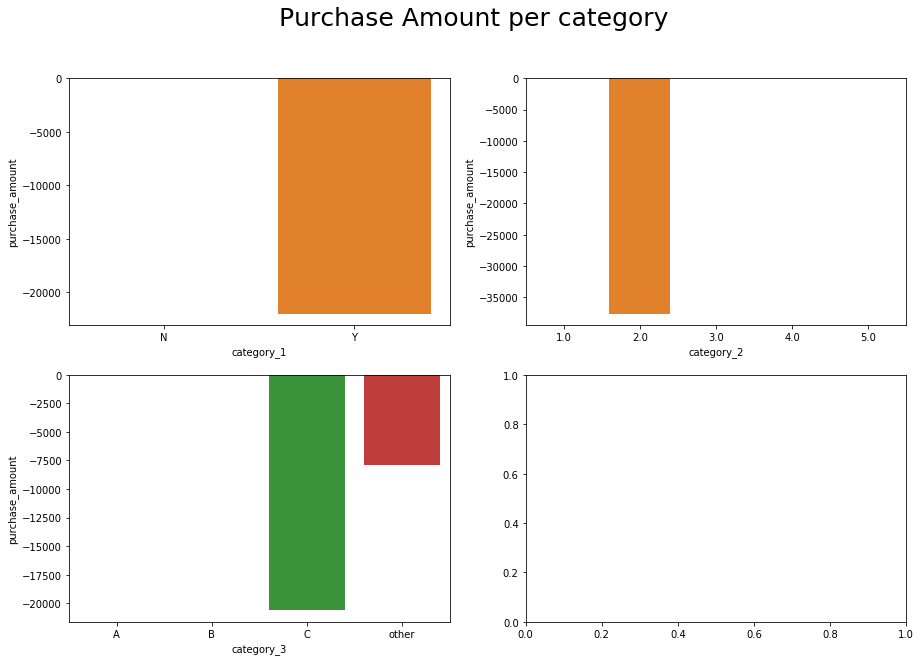

In [161]:
fig, ax = plt.subplots(2, 2, figsize=[15,10])
sns.barplot(x=newMerchDFGroupbycat1.category_1, y=newMerchDFGroupbycat1.purchase_amount, ax=ax[0, 0])
sns.barplot(x=newMerchDFGroupbycat2.category_2, y=newMerchDFGroupbycat2.purchase_amount, ax=ax[0, 1])
sns.barplot(x=newMerchDFGroupbycat3.category_3, y=newMerchDFGroupbycat3.purchase_amount, ax=ax[1, 0])
fig.suptitle("Purchase Amount per category", fontsize=25)
plt.show()

**Installment in category 1, Category 2 and Category 3**

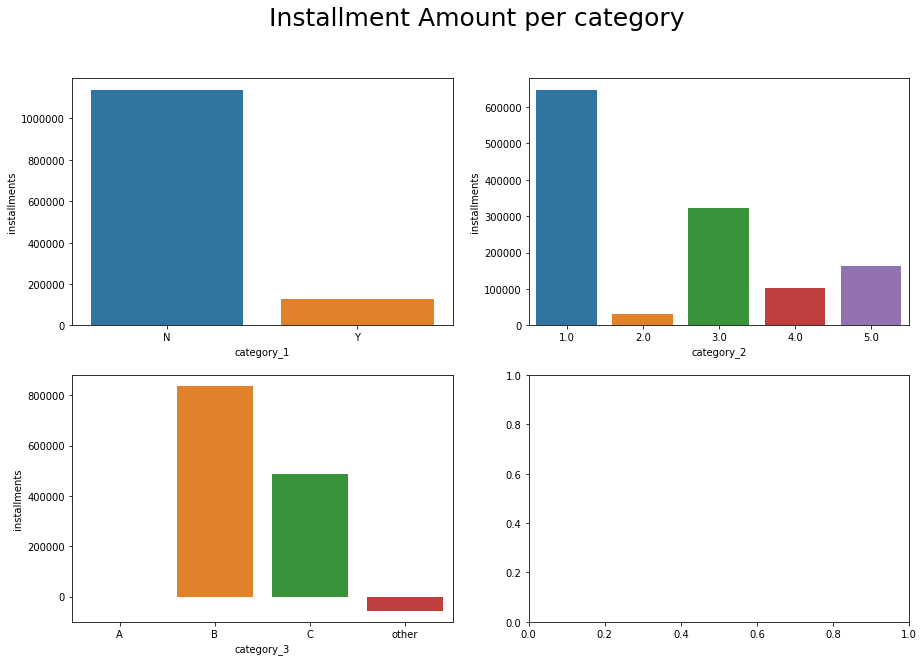

In [162]:
fig, ax = plt.subplots(2, 2, figsize=[15,10])
sns.barplot(x=newMerchDFGroupbycat1.category_1, y=newMerchDFGroupbycat1.installments, ax=ax[0, 0])
sns.barplot(x=newMerchDFGroupbycat2.category_2, y=newMerchDFGroupbycat2.installments, ax=ax[0, 1])
sns.barplot(x=newMerchDFGroupbycat3.category_3, y=newMerchDFGroupbycat3.installments, ax=ax[1, 0])
fig.suptitle("Installment Amount per category", fontsize=25)
plt.show()

In [163]:
histDFGroupbymerchCatID = groupByAgg(histDF, 'merchant_category_id', aggfuncEDAgrp)

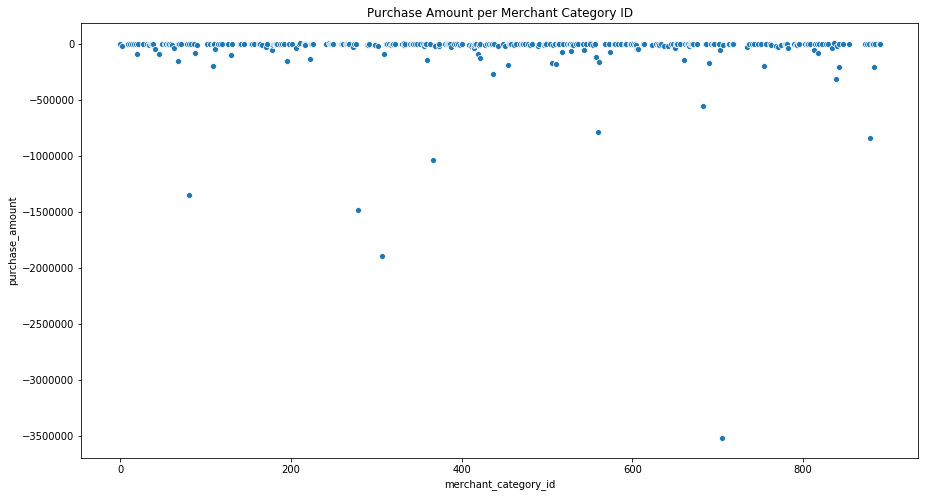

In [164]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x=histDFGroupbymerchCatID.merchant_category_id, y=histDFGroupbymerchCatID.purchase_amount)
plt.title("Purchase Amount per Merchant Category ID")
plt.show()

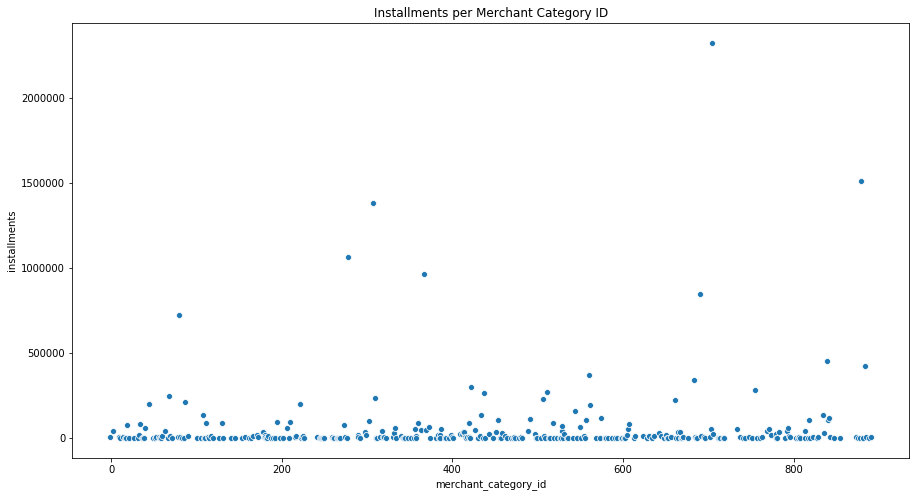

In [165]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x=histDFGroupbymerchCatID.merchant_category_id, y=histDFGroupbymerchCatID.installments)
plt.title("Installments per Merchant Category ID")
plt.show()

**Purchase Amount Per Subsector ID**

In [146]:
newMerchDFGrpBysubsector = groupByAgg(newMerchDF, 'subsector_id', aggfuncEDAgrp)

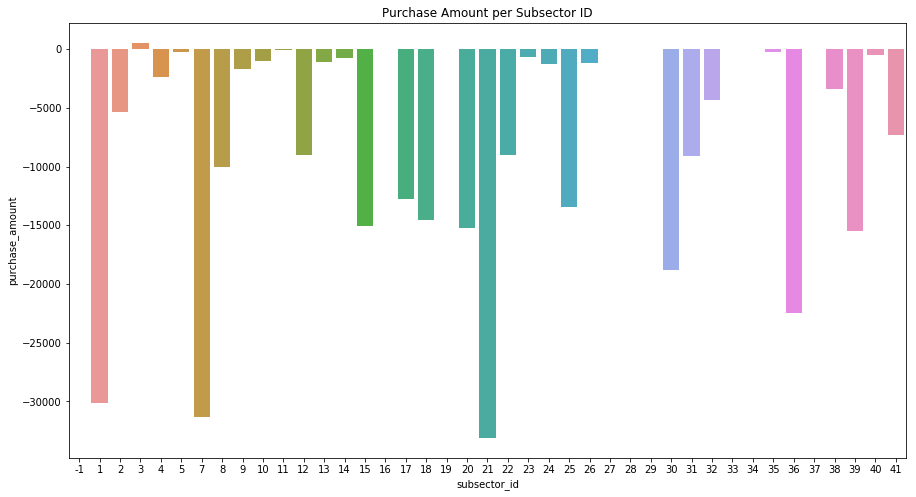

In [167]:
plt.figure(figsize=(15,8))
sns.barplot(x=newMerchDFGrpBysubsector.subsector_id, y=newMerchDFGrpBysubsector.purchase_amount)
plt.title("Purchase Amount per Subsector ID")
plt.show()

**Installments Per Subsector ID**

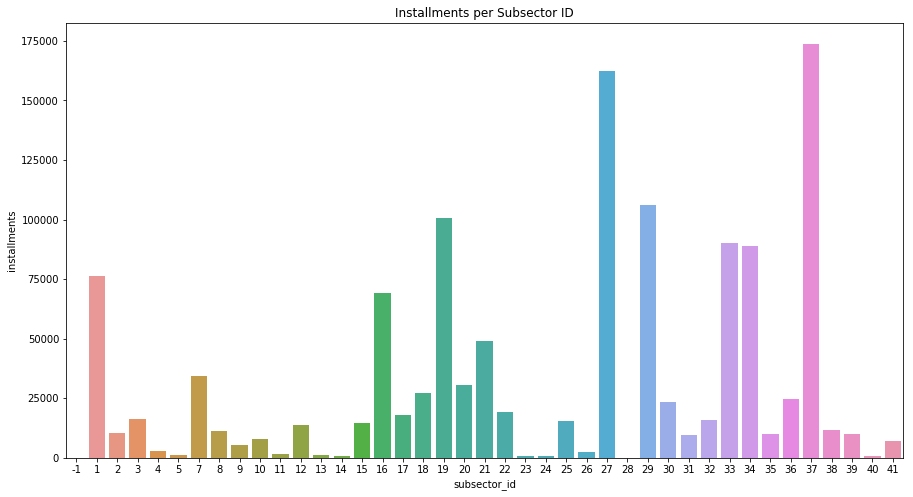

In [168]:
plt.figure(figsize=(15,8))
sns.barplot(x=newMerchDFGrpBysubsector.subsector_id, y=newMerchDFGrpBysubsector.installments)
plt.title("Installments per Subsector ID")
plt.show()

#### Train Data

In [51]:
trainDF = reduce_mem_usage(pd.read_csv(trainFilePath, parse_dates=["first_active_month"])) # read train.csv file to a dataframe

Mem. usage decreased to  4.04 Mb (56.2% reduction)


In [170]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int8
feature_2             201917 non-null int8
feature_3             201917 non-null int8
target                201917 non-null float16
dtypes: datetime64[ns](1), float16(1), int8(3), object(1)
memory usage: 4.0+ MB


### Target distribution

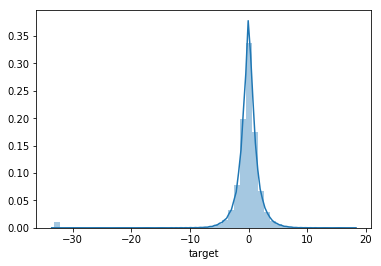

In [171]:
#plt.hist(trainDF.target)
sns.distplot(trainDF.target)
plt.show()

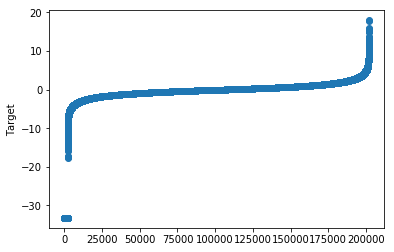

In [172]:
plt.scatter(x=range(trainDF.target.shape[0]), y=np.sort(trainDF.target.values))
plt.ylabel("Target")
plt.show()

#### EDA

**Number of cards first used on monthly basis**

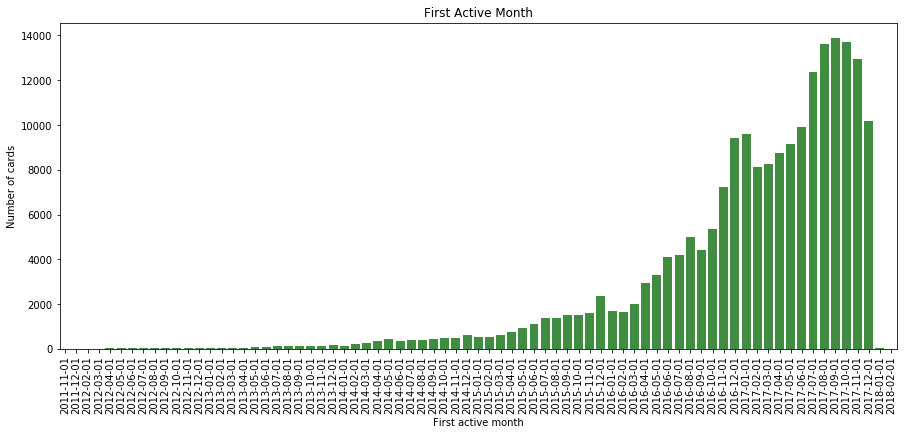

In [174]:
activemonths = trainDF.first_active_month.dt.date.value_counts()
activemonths = activemonths.sort_index()
plt.figure(figsize=(15,6))
sns.barplot(activemonths.index, activemonths.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month')
plt.ylabel('Number of cards')
plt.title("First Active Month")
plt.show()

**Loyalty Score distribution of Feature 1**

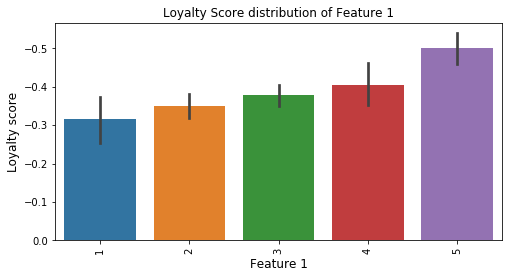

In [175]:
plt.figure(figsize=(8,4))
sns.barplot(x="feature_1", y="target", data=trainDF)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Loyalty Score distribution of Feature 1")
plt.gca().invert_yaxis()
plt.show()

**Loyalty Score distribution of Feature 2**

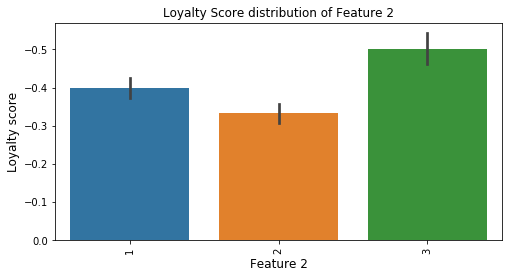

In [176]:
plt.figure(figsize=(8,4))
sns.barplot(x="feature_2", y="target", data=trainDF)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Loyalty Score distribution of Feature 2")
plt.gca().invert_yaxis()
plt.show()

**Loyalty Score distribution of Feature 2**

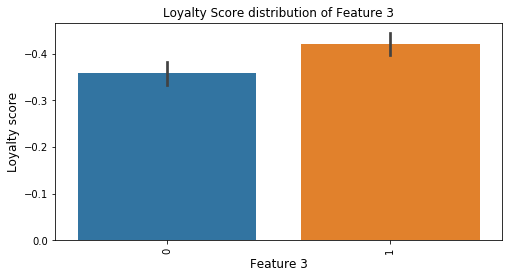

In [177]:
plt.figure(figsize=(8,4))
sns.barplot(x="feature_3", y="target", data=trainDF)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Loyalty Score distribution of Feature 3")
plt.gca().invert_yaxis()
plt.show()

#### Test Data

In [178]:
testDF = reduce_mem_usage(pd.read_csv(testFilePath, parse_dates=["first_active_month"])) # read test.csv file to a dataframe

Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [179]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null datetime64[ns]
card_id               123623 non-null object
feature_1             123623 non-null int8
feature_2             123623 non-null int8
feature_3             123623 non-null int8
dtypes: datetime64[ns](1), int8(3), object(1)
memory usage: 2.2+ MB


## Feature Engineering

1. Categorical value is converted to numerical feature using one-hot encoding. This converted numerical feature will be used to perform aggergate functions such as mean, sum, count etc
2. Transactions are grouped by card id by applying aggregate functions mean, std devation, count

In [52]:
merchDF.category_4 = binarize(merchDF.category_4)
merchDF.category_1 = binarize(merchDF.category_1)

In [53]:
merchDF = pd.get_dummies(merchDF, columns=['category_2', 
                                           'most_recent_sales_range', 
                                           'most_recent_purchases_range'])

In [54]:
merchDFMergingFeatures = ['merchant_id','numerical_1', 'numerical_2', 
                          'category_2_0.0', 'category_2_1.0', 
                          'category_2_2.0', 'category_2_3.0', 
                          'category_2_4.0', 'category_2_5.0', 
                          'category_4', 'category_1']
merchDFForMerging = merchDF[merchDFMergingFeatures]

In [183]:
merchDFForMerging.head()

,merchant_id,numerical_1,numerical_2,category_2_0.0,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_4,category_1
0,M_ID_838061e48c,0.011482,0.008095,0,1,0,0,0,0,0,0
1,M_ID_9339d880ad,0.011482,0.008095,0,1,0,0,0,0,0,0
2,M_ID_e726bbae1e,0.011482,0.008095,0,0,0,0,0,1,0,0
3,M_ID_a70e9c5f81,0.011482,0.008095,1,0,0,0,0,0,1,1
4,M_ID_64456c37ce,0.011482,0.008095,1,0,0,0,0,0,1,1


In [ ]:
merchDFForMerging.columns

In [55]:
del merchDF

In [56]:
merchDFForMerging.columns = ['merchDF_'+col if col not in ['merchant_id'] else col for col in merchDFForMerging.columns]

In [ ]:
#merchDF.columns

In [ ]:
#histDF.columns

In [186]:
"""aggfunc_merch = {
    'merchant_id': 'nunique',
    'merchant_category_id': 'nunique',
    'numerical_1': ['mean', 'sum'],
    'numerical_2': ['mean', 'sum'],
    'active_months_lag3': ['mean', 'sum'],
    'active_months_lag6': ['mean', 'sum'],
    'active_months_lag12': ['mean', 'sum'],
    'most_recent_sales_range_A' : 'mean',
    'most_recent_sales_range_B' : 'mean',
    'most_recent_sales_range_C' : 'mean',
    'most_recent_sales_range_D' : 'mean',
    'most_recent_sales_range_E' : 'mean',
    'most_recent_purchases_range_A': 'mean',
    'most_recent_purchases_range_B': 'mean',
    'most_recent_purchases_range_C': 'mean',
    'most_recent_purchases_range_D': 'mean',
    'most_recent_purchases_range_E': 'mean'
}"""

"aggfunc_merch = {\n    'merchant_id': 'nunique',\n    'merchant_category_id': 'nunique',\n    'numerical_1': ['mean', 'sum'],\n    'numerical_2': ['mean', 'sum'],\n    'active_months_lag3': ['mean', 'sum'],\n    'active_months_lag6': ['mean', 'sum'],\n    'active_months_lag12': ['mean', 'sum'],\n    'most_recent_sales_range_A' : 'mean',\n    'most_recent_sales_range_B' : 'mean',\n    'most_recent_sales_range_C' : 'mean',\n    'most_recent_sales_range_D' : 'mean',\n    'most_recent_sales_range_E' : 'mean',\n    'most_recent_purchases_range_A': 'mean',\n    'most_recent_purchases_range_B': 'mean',\n    'most_recent_purchases_range_C': 'mean',\n    'most_recent_purchases_range_D': 'mean',\n    'most_recent_purchases_range_E': 'mean'\n}"

In [ ]:
#aggmerchDF = merchDF.groupby('merchant_id').aggregate(aggfunc_merch)

In [187]:
#aggmerchDF.columns = ['_'.join(col).strip() for col in aggmerchDF.columns.values]
#aggmerchDF.columns

In [ ]:
#aggmerchDF.reset_index(inplace=True)

In [ ]:
#aggmerchDFDup = aggmerchDF[aggmerchDF.duplicated(subset = ['merchant_id']) == True]

In [ ]:
#aggmerchDFDup.head()

In [ ]:
#merchDFDupGroupBy = merchDFDup.groupby('merchant_id')[merchDF.columns]

In [ ]:
#merchDF[merchDF.merchant_id == 'M_ID_c2b9ac2ea4']
#merchDFDupGroupBy.head()
#merchDFDup.head(10)

In [ ]:
#merchDFDup[['merchant_id', 'city_id']]

In [ ]:
#repeatedIDs = merchDFDup.merchant_id.value_counts().index

In [ ]:
#merchDFDuplicates = merchDF[merchDF.merchant_id.isin(repeatedIDs)]

In [ ]:
#merchDFDuplicates.head(25)

In [ ]:
#merchDFDuplicates[merchDFDuplicates.merchant_id == 'M_ID_ebbdb42da6']

In [ ]:
#merchDFDup.merchant_id.value_counts()

In [ ]:
#aggmerchDF.head()

In [ ]:
#aggmerchDF.columns = ['merchDF_'+col if col != 'merchant_id' else col for col in aggmerchDF.columns.values]
#aggmerchDF.columns

In [ ]:
#del merchDF
#del aggmerchDFDup

## Historical Transactions

In [57]:
histDF = pd.merge(histDF, merchDFForMerging, on = 'merchant_id', how = 'left')

**Add mean of Purchase Amount by grouping Category_2 and Category_3**

In [58]:
for col in ['category_2','category_3']:
    histDF[col+'_purchaseAmt_mean'] = histDF.groupby([col])['purchase_amount'].transform('mean')

In [47]:
#for col in ['category_2','category_3']:
#    histDF[col+'_purchaseAmt_sum'] = histDF.groupby([card_id, col, 'month'])['purchase_amount'].transform(['sum', 'mean'])

In [59]:
histDF.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,month,dayofweek,weekofyear,weekend,hour,month_diff,merchDF_numerical_1,merchDF_numerical_2,merchDF_category_2_0.0,merchDF_category_2_1.0,merchDF_category_2_2.0,merchDF_category_2_3.0,merchDF_category_2_4.0,merchDF_category_2_5.0,merchDF_category_4,merchDF_category_1,category_2_purchaseAmt_mean,category_3_purchaseAmt_mean
0,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,6,25,1,15,13,0.011482,0.008095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.613957,-0.64406
1,Y,C_ID_4e6213e9bc,88,N,0.0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,5,28,1,12,14,0.011482,0.008095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.613957,-0.64406
2,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,2,32,0,22,14,0.011482,0.008095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.613957,-0.64406
3,Y,C_ID_4e6213e9bc,88,N,0.0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,9,5,35,1,10,14,0.011482,0.008095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.613957,-0.64406
4,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,3,4,10,0,1,14,0.011482,0.008095,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.613957,-0.64406


In [60]:
histDF.tail()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,month,dayofweek,weekofyear,weekend,hour,month_diff,merchDF_numerical_1,merchDF_numerical_2,merchDF_category_2_0.0,merchDF_category_2_1.0,merchDF_category_2_2.0,merchDF_category_2_3.0,merchDF_category_2_4.0,merchDF_category_2_5.0,merchDF_category_4,merchDF_category_1,category_2_purchaseAmt_mean,category_3_purchaseAmt_mean
30333775,Y,C_ID_2863d2fa95,-1,Y,1.0,B,360,M_ID_edd92b6720,-1,-0.632706,2017-01-20 08:52:04,3.0,-1,34,2017,1,4,3,0,8,25,0.011482,0.008095,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.561394,-0.619544
30333776,Y,C_ID_2863d2fa95,-1,Y,1.0,B,360,M_ID_edd92b6720,0,-0.632706,2017-02-20 04:40:50,3.0,-1,34,2017,2,0,8,0,4,25,0.011482,0.008095,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.561394,-0.619544
30333777,Y,C_ID_5c240d6e3c,3,N,0.0,A,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37,2017,12,1,52,0,18,15,0.011482,0.008095,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.613957,-0.644060
30333778,Y,C_ID_5c240d6e3c,331,N,0.0,A,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9,2017,11,4,47,0,14,15,0.011482,0.008095,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.613957,-0.644060
30333779,Y,C_ID_5c240d6e3c,331,N,0.0,A,514,M_ID_1a75f94f92,-2,1.134411,2017-10-26 14:09:40,1.0,16,9,2017,10,3,43,0,14,15,0.011482,0.008095,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.613957,-0.644060


In [ ]:
histDF.columns

In [ ]:
#histDF.info(null_counts=True)

In [ ]:
#histDF.category_3.value_counts()

In [ ]:
#histDF.category_3_mean.value_counts()

In [ ]:
#histDF.category_3_A.value_counts()

In [ ]:
#agghistDF.category_3_mean_mean.value_counts()
#histDF.category_3_mean

In [ ]:
#agghistDF.category_3_A_mean.value_counts()

**One Hot Encoding of categorical features Category_1, category_2, category_3**

In [61]:
histDF.authorized_flag = binarize(histDF.authorized_flag)
histDF.category_1 = binarize(histDF.category_1)

In [62]:
histDF = pd.get_dummies(histDF, columns=['category_2', 'category_3'])

In [ ]:
#histDF.info(null_counts=True)

In [ ]:
#histDF.head()

In [ ]:
#histDF = pd.merge(histDF, merchDF, on = 'merchant_id', how = 'left')

In [ ]:
#histDF.info(null_counts=True)

In [ ]:
#histDF[histDF.duplicated(subset=['merchant_id']) == True]

In [ ]:
histDF.columns

In [ ]:
#histDF = pd.get_dummies(histDF, columns=['merchDF_most_recent_purchases_range', 'merchDF_most_recent_sales_range'])

**Adding Aggregate Features**

In [ ]:
#histDF = pd.merge(histDF, aggmerchDF, on = 'merchant_id', how = 'left')

In [ ]:
#histDF.columns

In [ ]:
#histDF.head(15)

In [ ]:
aggfunc = {
    'authorized_flag': ['sum', 'mean'],
    'category_1':['sum', 'mean'],
    'category_2_1.0': 'mean',
    'category_2_2.0': 'mean',
    'category_2_3.0': 'mean',
    'category_2_4.0': 'mean',
    'category_2_5.0': 'mean',
    'category_3_A': 'mean',
    'category_3_B': 'mean',
    'category_3_C': 'mean',
    'category_3_other': 'mean',
    'state_id': 'nunique',
    'city_id': 'nunique',
    'purchase_amount': ['sum', 'mean', 'count', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    ##'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': ['min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'card_id': ['count'],
    'month_diff': ['mean'],
    'weekend' : ['sum', 'mean'],
    'month': 'nunique',
    'hour': 'nunique',
    'weekofyear': 'nunique',
    'dayofweek': 'nunique',
    'year': 'nunique',
    'subsector_id': 'nunique',
    'merchant_id': 'nunique',
    'merchant_category_id': 'nunique',
    'category_2_purchaseAmt_mean' : 'mean',
    'category_3_purchaseAmt_mean' : 'mean'
}

In [63]:
aggfunc = {
    'authorized_flag': ['sum', 'mean'],
    'category_1':['sum', 'mean'],
    'category_2_1.0': 'mean',
    'category_2_2.0': 'mean',
    'category_2_3.0': 'mean',
    'category_2_4.0': 'mean',
    'category_2_5.0': 'mean',
    'category_3_A': 'mean',
    'category_3_B': 'mean',
    'category_3_C': 'mean',
    'category_3_other': 'mean',
    'state_id': 'nunique',
    'city_id': 'nunique',
    'purchase_amount': ['sum', 'mean', 'count', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    ##'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': ['min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'card_id': ['count'],
    'month_diff': ['mean'],
    'weekend' : ['sum', 'mean'],
    'month': 'nunique',
    'hour': 'nunique',
    'weekofyear': 'nunique',
    'dayofweek': 'nunique',
    'year': 'nunique',
    'subsector_id': 'nunique',
    'merchant_id': 'nunique',
    'merchant_category_id': 'nunique',
    'category_2_purchaseAmt_mean' : 'mean',
    'category_3_purchaseAmt_mean' : 'mean',
    'merchDF_numerical_1': ['mean', 'sum'],
    'merchDF_numerical_2': ['mean', 'sum'],
    'merchDF_category_2_0.0': 'mean', 
    'merchDF_category_2_1.0':'mean',
    'merchDF_category_2_2.0':'mean', 
    'merchDF_category_2_3.0':'mean',
    'merchDF_category_2_4.0':'mean', 
    'merchDF_category_2_5.0':'mean',
    'merchDF_category_4': 'mean', 
    'merchDF_category_1': 'mean'
}       

In [56]:
#histDF.merchDF_most_recent_purchases_range.value_counts()
#del merchDF

In [64]:
agghistDF = histDF.groupby('card_id').aggregate(aggfunc)

In [65]:
agghistDF.columns = ['_'.join(col).strip() for col in agghistDF.columns.values]
#agghistDF.columns
agghistDF.reset_index(inplace=True)

In [ ]:
agghistDF.info()

**DateTime Features**
1. purchase_date_diff ---- purchase_date_max - purchase_date_min
2. purchase_date_average ----- purchase_date_diff/card_id_count
3. purchase_date_tillToday ----- Today's date - purchase_date_max

In [66]:
agghistDF['purchase_date_diff'] = (agghistDF['purchase_date_max'] - agghistDF['purchase_date_min']).dt.days
agghistDF['purchase_date_average'] = agghistDF['purchase_date_diff']/agghistDF['card_id_count']
agghistDF['purchase_date_tillToday'] = (datetime.datetime.today() - agghistDF['purchase_date_max']).dt.days

In [ ]:
agghistDF.head()

In [ ]:
histDF.head(10)

**Prefix agghistDF columns with 'histDF'**

In [67]:
agghistDF.columns = ['histDF_'+col if col != 'card_id' else col for col in agghistDF.columns.values]
agghistDF.columns

Index(['card_id', 'histDF_authorized_flag_sum', 'histDF_authorized_flag_mean',
       'histDF_category_1_sum', 'histDF_category_1_mean',
       'histDF_category_2_1.0_mean', 'histDF_category_2_2.0_mean',
       'histDF_category_2_3.0_mean', 'histDF_category_2_4.0_mean',
       'histDF_category_2_5.0_mean', 'histDF_category_3_A_mean',
       'histDF_category_3_B_mean', 'histDF_category_3_C_mean',
       'histDF_category_3_other_mean', 'histDF_state_id_nunique',
       'histDF_city_id_nunique', 'histDF_purchase_amount_sum',
       'histDF_purchase_amount_mean', 'histDF_purchase_amount_count',
       'histDF_purchase_amount_max', 'histDF_purchase_amount_min',
       'histDF_purchase_amount_std', 'histDF_installments_sum',
       'histDF_installments_mean', 'histDF_installments_max',
       'histDF_installments_min', 'histDF_installments_std',
       'histDF_purchase_date_min', 'histDF_purchase_date_max',
       'histDF_month_lag_mean', 'histDF_month_lag_max', 'histDF_month_lag_min',
     

In [68]:
agghistDF.head()

,card_id,histDF_authorized_flag_sum,histDF_authorized_flag_mean,histDF_category_1_sum,histDF_category_1_mean,histDF_category_2_1.0_mean,histDF_category_2_2.0_mean,histDF_category_2_3.0_mean,histDF_category_2_4.0_mean,histDF_category_2_5.0_mean,histDF_category_3_A_mean,histDF_category_3_B_mean,histDF_category_3_C_mean,histDF_category_3_other_mean,histDF_state_id_nunique,histDF_city_id_nunique,histDF_purchase_amount_sum,histDF_purchase_amount_mean,histDF_purchase_amount_count,histDF_purchase_amount_max,histDF_purchase_amount_min,histDF_purchase_amount_std,histDF_installments_sum,histDF_installments_mean,histDF_installments_max,histDF_installments_min,histDF_installments_std,histDF_purchase_date_min,histDF_purchase_date_max,histDF_month_lag_mean,histDF_month_lag_max,histDF_month_lag_min,histDF_month_lag_std,histDF_card_id_count,histDF_month_diff_mean,histDF_weekend_sum,histDF_weekend_mean,histDF_month_nunique,histDF_hour_nunique,histDF_weekofyear_nunique,histDF_dayofweek_nunique,histDF_year_nunique,histDF_subsector_id_nunique,histDF_merchant_id_nunique,histDF_merchant_category_id_nunique,histDF_category_2_purchaseAmt_mean_mean,histDF_category_3_purchaseAmt_mean_mean,histDF_merchDF_numerical_1_mean,histDF_merchDF_numerical_1_sum,histDF_merchDF_numerical_2_mean,histDF_merchDF_numerical_2_sum,histDF_merchDF_category_2_0.0_mean,histDF_merchDF_category_2_1.0_mean,histDF_merchDF_category_2_2.0_mean,histDF_merchDF_category_2_3.0_mean,histDF_merchDF_category_2_4.0_mean,histDF_merchDF_category_2_5.0_mean,histDF_merchDF_category_4_mean,histDF_merchDF_category_1_mean,histDF_purchase_date_diff,histDF_purchase_date_average,histDF_purchase_date_tillToday
0,C_ID_00007093c1,114,0.765101,28,0.187919,0.000000,0.000000,0.993289,0.0,0.006711,0.000000,0.838926,0.161074,0.000000,3,4,-77.131271,-0.517660,149,1.220841,-0.728876,0.285682,192.000000,1.288591,6.000000,1.0,0.764900,2017-02-14 14:00:43,2018-02-27 05:14:57,-5.852349,0,-12,3.453114,149,13.664430,25,0.167785,12,18,39,7,2,13,29,18,-0.561648,-0.542178,0.011482,1.710938,0.008095,1.206055,0.187919,0.000000,0.000000,0.812081,0.0,0.000000,0.328859,0.187919,377,2.530201,405
1,C_ID_0001238066,120,0.975610,2,0.016260,0.772358,0.000000,0.065041,0.0,0.162602,0.000000,0.715447,0.260163,0.024390,6,18,-72.447197,-0.589002,123,0.768095,-0.734887,0.190235,197.035226,1.601912,9.035226,-1.0,1.442908,2017-09-28 22:25:14,2018-02-27 16:18:59,-1.813008,0,-5,1.288980,123,13.357724,52,0.422764,6,20,23,7,2,17,65,29,-0.608137,-0.483314,0.011482,1.412109,0.008095,0.995605,0.040650,0.813008,0.000000,0.000000,0.0,0.146341,0.162602,0.040650,151,1.227642,404
2,C_ID_0001506ef0,64,0.941176,0,0.000000,0.058824,0.000000,0.941176,0.0,0.000000,0.985294,0.014706,0.000000,0.000000,2,3,-36.310547,-0.533979,68,1.220841,-0.740491,0.449564,1.000000,0.014706,1.000000,0.0,0.121268,2017-01-14 16:16:01,2018-02-17 12:33:56,-4.750000,0,-13,4.201546,68,13.720588,34,0.500000,11,15,24,7,2,12,28,19,-0.564486,-0.643699,0.011482,0.780762,0.008095,0.550293,0.058824,0.000000,0.000000,0.941176,0.0,0.000000,0.985294,0.058824,398,5.852941,414
3,C_ID_0001793786,195,0.878378,2,0.009009,0.076577,0.342342,0.581081,0.0,0.000000,0.977477,0.022523,0.000000,0.000000,4,10,-55.086704,-0.248138,222,1.220841,-0.743241,0.571976,5.000000,0.022523,1.000000,0.0,0.148711,2017-01-21 10:15:21,2017-10-31 20:20:18,-3.324324,0,-9,2.295627,222,17.536036,37,0.166667,10,21,33,7,1,24,119,48,-0.575555,-0.643508,0.011482,2.548828,0.008095,1.796875,0.144144,0.022523,0.792793,0.040541,0.0,0.000000,0.707207,0.144144,283,1.274775,523
4,C_ID_000183fdda,142,0.953020,4,0.026846,0.080537,0.006711,0.906040,0.0,0.006711,0.000000,0.724832,0.248322,0.026846,7,9,-75.105896,-0.504066,149,1.220841,-0.737892,0.414616,263.211356,1.766519,9.035226,-1.0,1.937963,2017-08-07 09:49:14,2018-02-25 20:57:08,-2.449664,0,-6,1.901053,149,13.557047,35,0.234899,7,19,27,7,2,21,73,36,-0.566080,-0.487866,0.011482,1.710938,0.008095,1.206055,0.134228,0.000000,0.000000,0.865772,0.0,0.000000,0.953020,0.134228,202,1.3

In [69]:
del histDF

In [ ]:
#histDF.info()

### Feature Engineering of newMerchDF

In [ ]:
#newMerchDF = pd.merge(newMerchDF, aggmerchDF, on = 'merchant_id', how = 'left')

In [70]:
newMerchDF = pd.merge(newMerchDF, merchDFForMerging, on = 'merchant_id', how = 'left')

**Add mean of Category_2 and Category_3**

In [71]:
for col in ['category_2','category_3']:
    newMerchDF[col+'_purchaseAmt_mean'] = newMerchDF.groupby([col])['purchase_amount'].transform('mean')

**One Hot Encoding of categorical features Category_1, category_2, category_3**

In [72]:
newMerchDF.authorized_flag = binarize(newMerchDF.authorized_flag)
newMerchDF.category_1 = binarize(newMerchDF.category_1)

In [73]:
newMerchDF = pd.get_dummies(newMerchDF, columns=['category_2', 'category_3'])

**Adding Aggregate Features**

In [74]:
aggnewMerchDF = newMerchDF.groupby('card_id').aggregate(aggfunc)

In [75]:
aggnewMerchDF.columns = ['_'.join(col).strip() for col in aggnewMerchDF.columns.values]
aggnewMerchDF.reset_index(inplace=True)

In [80]:
aggnewMerchDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290001 entries, 0 to 290000
Data columns (total 62 columns):
card_id                                        290001 non-null object
newMerchDF_authorized_flag_sum                 290001 non-null int64
newMerchDF_authorized_flag_mean                290001 non-null int64
newMerchDF_category_1_sum                      290001 non-null int64
newMerchDF_category_1_mean                     290001 non-null float64
newMerchDF_category_2_1.0_mean                 290001 non-null float64
newMerchDF_category_2_2.0_mean                 290001 non-null float64
newMerchDF_category_2_3.0_mean                 290001 non-null float64
newMerchDF_category_2_4.0_mean                 290001 non-null float64
newMerchDF_category_2_5.0_mean                 290001 non-null float64
newMerchDF_category_3_A_mean                   290001 non-null float64
newMerchDF_category_3_B_mean                   290001 non-null float64
newMerchDF_category_3_C_mean                

**Adding Following Features**
1. purchase_date_diff - difference in maximum purchase date and minium purchase date
2. purchase_date_diff_average - difference in maximum purchase date and minium purchase date/ number of cards
3. purchase_days_tillToday - number of days from last puchase date

In [76]:
aggnewMerchDF['purchase_date_diff'] = (aggnewMerchDF['purchase_date_max'] - aggnewMerchDF['purchase_date_min']).dt.days
aggnewMerchDF['purchase_date_diff_average'] = aggnewMerchDF['purchase_date_diff']/aggnewMerchDF['card_id_count']
aggnewMerchDF['purchase_days_tillToday'] = (datetime.datetime.today() - aggnewMerchDF['purchase_date_max']).dt.days

**Prefix agghistDF columns with 'newMerchDF_'**

In [77]:
aggnewMerchDF.columns = ['newMerchDF_'+col if col != 'card_id' else col for col in aggnewMerchDF.columns.values]
aggnewMerchDF.columns

Index(['card_id', 'newMerchDF_authorized_flag_sum',
       'newMerchDF_authorized_flag_mean', 'newMerchDF_category_1_sum',
       'newMerchDF_category_1_mean', 'newMerchDF_category_2_1.0_mean',
       'newMerchDF_category_2_2.0_mean', 'newMerchDF_category_2_3.0_mean',
       'newMerchDF_category_2_4.0_mean', 'newMerchDF_category_2_5.0_mean',
       'newMerchDF_category_3_A_mean', 'newMerchDF_category_3_B_mean',
       'newMerchDF_category_3_C_mean', 'newMerchDF_category_3_other_mean',
       'newMerchDF_state_id_nunique', 'newMerchDF_city_id_nunique',
       'newMerchDF_purchase_amount_sum', 'newMerchDF_purchase_amount_mean',
       'newMerchDF_purchase_amount_count', 'newMerchDF_purchase_amount_max',
       'newMerchDF_purchase_amount_min', 'newMerchDF_purchase_amount_std',
       'newMerchDF_installments_sum', 'newMerchDF_installments_mean',
       'newMerchDF_installments_max', 'newMerchDF_installments_min',
       'newMerchDF_installments_std', 'newMerchDF_purchase_date_min',
     

In [78]:
aggnewMerchDF.to_csv("aggnewMerchDF.csv", index=False)
agghistDF.to_csv("agghistDF.csv", index=False)

In [79]:
aggnewMerchDF.head()

,card_id,newMerchDF_authorized_flag_sum,newMerchDF_authorized_flag_mean,newMerchDF_category_1_sum,newMerchDF_category_1_mean,newMerchDF_category_2_1.0_mean,newMerchDF_category_2_2.0_mean,newMerchDF_category_2_3.0_mean,newMerchDF_category_2_4.0_mean,newMerchDF_category_2_5.0_mean,newMerchDF_category_3_A_mean,newMerchDF_category_3_B_mean,newMerchDF_category_3_C_mean,newMerchDF_category_3_other_mean,newMerchDF_state_id_nunique,newMerchDF_city_id_nunique,newMerchDF_purchase_amount_sum,newMerchDF_purchase_amount_mean,newMerchDF_purchase_amount_count,newMerchDF_purchase_amount_max,newMerchDF_purchase_amount_min,newMerchDF_purchase_amount_std,newMerchDF_installments_sum,newMerchDF_installments_mean,newMerchDF_installments_max,newMerchDF_installments_min,newMerchDF_installments_std,newMerchDF_purchase_date_min,newMerchDF_purchase_date_max,newMerchDF_month_lag_mean,newMerchDF_month_lag_max,newMerchDF_month_lag_min,newMerchDF_month_lag_std,newMerchDF_card_id_count,newMerchDF_month_diff_mean,newMerchDF_weekend_sum,newMerchDF_weekend_mean,newMerchDF_month_nunique,newMerchDF_hour_nunique,newMerchDF_weekofyear_nunique,newMerchDF_dayofweek_nunique,newMerchDF_year_nunique,newMerchDF_subsector_id_nunique,newMerchDF_merchant_id_nunique,newMerchDF_merchant_category_id_nunique,newMerchDF_category_2_purchaseAmt_mean_mean,newMerchDF_category_3_purchaseAmt_mean_mean,newMerchDF_merchDF_numerical_1_mean,newMerchDF_merchDF_numerical_1_sum,newMerchDF_merchDF_numerical_2_mean,newMerchDF_merchDF_numerical_2_sum,newMerchDF_merchDF_category_2_0.0_mean,newMerchDF_merchDF_category_2_1.0_mean,newMerchDF_merchDF_category_2_2.0_mean,newMerchDF_merchDF_category_2_3.0_mean,newMerchDF_merchDF_category_2_4.0_mean,newMerchDF_merchDF_category_2_5.0_mean,newMerchDF_merchDF_category_4_mean,newMerchDF_merchDF_category_1_mean,newMerchDF_purchase_date_diff,newMerchDF_purchase_date_diff_average,newMerchDF_purchase_days_tillToday
0,C_ID_00007093c1,3,1,0,0.000000,0.666667,0.000000,0.333333,0.0,0.000000,0.0,1.000000,0.000000,0.000000,2,2,-1.985352,-0.661621,3,-0.656738,-0.671875,0.008736,3.00000,1.000000,1.00000,1.0,0.000000,2018-04-03 11:13:35,2018-04-09 16:23:59,2.000000,2,2,0.000000,3,14.000000,0,0.000000,1,2,2,2,1,2,2,2,-0.569824,-0.615234,0.011482,0.034454,0.008095,0.024292,0.666667,0.000000,0.000000,0.333333,0.0,0.000000,1.000000,0.666667,6,2.000000,363
1,C_ID_0001238066,27,1,2,0.074074,0.777778,0.000000,0.111111,0.0,0.111111,0.0,0.814815,0.148148,0.037037,4,8,-15.523438,-0.575195,27,-0.078308,-0.740723,0.171265,37.87034,1.402605,5.43517,-1.0,1.344004,2018-03-01 16:48:27,2018-04-30 19:57:30,1.333333,2,1,0.480384,27,13.222222,12,0.444444,2,16,9,6,1,9,26,15,-0.579590,-0.525391,0.011482,0.298584,0.008095,0.210449,0.230769,0.653846,0.000000,0.000000,0.0,0.115385,0.384615,0.230769,60,2.222222,342
2,C_ID_0001506ef0,2,1,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,1,1,-1.447266,-0.723633,2,-0.715332,-0.731934,0.011742,0.00000,0.000000,0.00000,0.0,0.000000,2018-03-16 22:21:58,2018-03-22 09:14:30,1.000000,1,1,0.000000,2,13.000000,0,0.000000,1,2,2,2,1,2,2,2,-0.534180,-0.634277,0.011482,0.011482,0.008095,0.008095,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,0.000000,5,2.500000,381
3,C_ID_0001793786,31,1,0,0.000000,0.483871,0.258065,0.225806,0.0,0.032258,1.0,0.000000,0.000000,0.000000,5,7,-3.187500,-0.102783,31,1.462891,-0.737793,0.673340,0.00000,0.000000,0.00000,0.0,0.000000,2017-11-15 15:44:20,2017-12-31 17:35:56,1.322581,2,1,0.475191,31,17.064516,14,0.451613,2,10,6,6,1,14,31,21,-0.571289,-0.634277,0.011482,0.355957,0.008095,0.250977,0.129032,0.387097,0.322581,0.161290,0.0,0.000000,0.709677,0.129032,46,1.483871,462
4,C_ID_000183fdda,11,1,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.545455,0.363636,0.090909,2,2,-6.589844,-0.599121,11,-0.107666,-0.732422,0.182861,16.00000,1.454545,4.00000,-1.0,1.293340,2018-03-02 12:26:26,2018-04-30 14:59:53,1.272727,2,1,0.467099,11,13.727273,2,0.181818,2,8,7,6,1,6,11,9,-0.534180,-0.39502

In [81]:
del newMerchDF
#del histDF
#del trainDF
#del testDF

#### Merge Cells

1. Group by data frames generated by aggregate functions from histroical and new merchant data will be merged with train and test data
2. Feature engineering is performed on merged train and test dataframe
3. Training data will be trained on **XGBOOST** ML algorithm
4. **RandomizedSearchCV** will be used for tunning XGBOOST algorithm hyperparameters
5. **RMSE** will be used for evaluation
6. Feature importance will be generated on the trained model.

In [82]:
"""Merge group by aggregate dataframe generated from histroical transactions (aggnewMerchDF) and 
new merchant transactions (aggnewMerchDF) to train dataset"""


trainDF = pd.merge(trainDF, agghistDF, on = 'card_id', how = 'left')
trainDF = pd.merge(trainDF, aggnewMerchDF, on = 'card_id', how = 'left')

In [83]:
testDF = reduce_mem_usage(pd.read_csv(testFilePath, parse_dates=["first_active_month"])) # read test.csv file to a dataframe

Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [84]:
"""Merge group by aggregate dataframe generated from histroical transactions (aggnewMerchDF) and 
new merchant transactions (aggnewMerchDF) to train dataset"""

testDF = pd.merge(testDF, agghistDF, on = 'card_id', how = 'left')
testDF = pd.merge(testDF, aggnewMerchDF, on = 'card_id', how = 'left')

In [85]:
for df in [trainDF,testDF]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['histDF_first_buy'] = (df['histDF_purchase_date_min'] - df['first_active_month']).dt.days
    df['newMerchDF_hist_first_buy'] = (df['newMerchDF_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['histDF_purchase_date_max','histDF_purchase_date_min','newMerchDF_purchase_date_max',\
                     'newMerchDF_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['newMerchDF_card_id_count']+df['histDF_card_id_count']
    df['purchase_amount_total'] = df['newMerchDF_purchase_amount_sum']+df['histDF_purchase_amount_sum']

In [86]:
trainDF['outliers'] = 0
trainDF.loc[trainDF['target'] < -30, 'outliers'] = 1
trainDF['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [87]:
for f in ['feature_1','feature_2','feature_3']:
    order_label = trainDF.groupby([f])['outliers'].mean()
    trainDF[f] = trainDF[f].map(order_label)
    testDF[f] = testDF[f].map(order_label)

In [88]:
trainDF.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,histDF_authorized_flag_sum,histDF_authorized_flag_mean,histDF_category_1_sum,histDF_category_1_mean,histDF_category_2_1.0_mean,histDF_category_2_2.0_mean,histDF_category_2_3.0_mean,histDF_category_2_4.0_mean,histDF_category_2_5.0_mean,histDF_category_3_A_mean,histDF_category_3_B_mean,histDF_category_3_C_mean,histDF_category_3_other_mean,histDF_state_id_nunique,histDF_city_id_nunique,histDF_purchase_amount_sum,histDF_purchase_amount_mean,histDF_purchase_amount_count,histDF_purchase_amount_max,histDF_purchase_amount_min,histDF_purchase_amount_std,histDF_installments_sum,histDF_installments_mean,histDF_installments_max,histDF_installments_min,histDF_installments_std,histDF_purchase_date_min,histDF_purchase_date_max,histDF_month_lag_mean,histDF_month_lag_max,histDF_month_lag_min,histDF_month_lag_std,histDF_card_id_count,histDF_month_diff_mean,histDF_weekend_sum,histDF_weekend_mean,histDF_month_nunique,histDF_hour_nunique,histDF_weekofyear_nunique,histDF_dayofweek_nunique,histDF_year_nunique,histDF_subsector_id_nunique,histDF_merchant_id_nunique,histDF_merchant_category_id_nunique,histDF_category_2_purchaseAmt_mean_mean,histDF_category_3_purchaseAmt_mean_mean,histDF_merchDF_numerical_1_mean,histDF_merchDF_numerical_1_sum,histDF_merchDF_numerical_2_mean,histDF_merchDF_numerical_2_sum,histDF_merchDF_category_2_0.0_mean,histDF_merchDF_category_2_1.0_mean,histDF_merchDF_category_2_2.0_mean,histDF_merchDF_category_2_3.0_mean,histDF_merchDF_category_2_4.0_mean,histDF_merchDF_category_2_5.0_mean,histDF_merchDF_category_4_mean,histDF_merchDF_category_1_mean,histDF_purchase_date_diff,histDF_purchase_date_average,histDF_purchase_date_tillToday,newMerchDF_authorized_flag_sum,newMerchDF_authorized_flag_mean,newMerchDF_category_1_sum,newMerchDF_category_1_mean,newMerchDF_category_2_1.0_mean,newMerchDF_category_2_2.0_mean,newMerchDF_category_2_3.0_mean,newMerchDF_category_2_4.0_mean,newMerchDF_category_2_5.0_mean,newMerchDF_category_3_A_mean,newMerchDF_category_3_B_mean,newMerchDF_category_3_C_mean,newMerchDF_category_3_other_mean,newMerchDF_state_id_nunique,newMerchDF_city_id_nunique,newMerchDF_purchase_amount_sum,newMerchDF_purchase_amount_mean,newMerchDF_purchase_amount_count,newMerchDF_purchase_amount_max,newMerchDF_purchase_amount_min,newMerchDF_purchase_amount_std,newMerchDF_installments_sum,newMerchDF_installments_mean,newMerchDF_installments_max,newMerchDF_installments_min,newMerchDF_installments_std,newMerchDF_purchase_date_min,newMerchDF_purchase_date_max,newMerchDF_month_lag_mean,newMerchDF_month_lag_max,newMerchDF_month_lag_min,newMerchDF_month_lag_std,newMerchDF_card_id_count,newMerchDF_month_diff_mean,newMerchDF_weekend_sum,newMerchDF_weekend_mean,newMerchDF_month_nunique,newMerchDF_hour_nunique,newMerchDF_weekofyear_nunique,newMerchDF_dayofweek_nunique,newMerchDF_year_nunique,newMerchDF_subsector_id_nunique,newMerchDF_merchant_id_nunique,newMerchDF_merchant_category_id_nunique,newMerchDF_category_2_purchaseAmt_mean_mean,newMerchDF_category_3_purchaseAmt_mean_mean,newMerchDF_merchDF_numerical_1_mean,newMerchDF_merchDF_numerical_1_sum,newMerchDF_merchDF_numerical_2_mean,newMerchDF_merchDF_numerical_2_sum,newMerchDF_merchDF_category_2_0.0_mean,newMerchDF_merchDF_category_2_1.0_mean,newMerchDF_merchDF_category_2_2.0_mean,newMerchDF_merchDF_category_2_3.0_mean,newMerchDF_merchDF_category_2_4.0_mean,newMerchDF_merchDF_category_2_5.0_mean,newMerchDF_merchDF_category_4_mean,newMerchDF_merchDF_category_1_mean,newMerchDF_purchase_date_diff,newMerchDF_purchase_date_diff_average,newMerchDF_purchase_days_tillToday,dayofweek,weekofyear,month,elapsed_time,histDF_first_buy,newMerchDF_hist_first_buy,card_id_total,purchase_amount_total,outliers
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820312,252,0.950943,0,0.000000,0.988679,0.0,0.000000,0.000000,0.011321,0.984906,0.015094,0.000000,0.000000,3,7,-170.446365,-0.643194,265,1.220841,-0.739395,0.159722,4.000000,0.015094,1.

In [89]:
del agghistDF
del aggnewMerchDF

In [153]:
trainDF[trainDF.newMerchDF_purchase_amount_sum.isnull() == True]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,histDF_authorized_flag_sum,histDF_authorized_flag_mean,histDF_category_1_sum,histDF_category_1_mean,histDF_category_2_1.0_mean,histDF_category_2_2.0_mean,histDF_category_2_3.0_mean,histDF_category_2_4.0_mean,histDF_category_2_5.0_mean,histDF_category_3_A_mean,histDF_category_3_B_mean,histDF_category_3_C_mean,histDF_category_3_other_mean,histDF_state_id_nunique,histDF_city_id_nunique,histDF_purchase_amount_sum,histDF_purchase_amount_mean,histDF_purchase_amount_count,histDF_purchase_amount_max,histDF_purchase_amount_min,histDF_purchase_amount_std,histDF_installments_sum,histDF_installments_mean,histDF_installments_max,histDF_installments_min,histDF_installments_std,histDF_purchase_date_min,histDF_purchase_date_max,histDF_month_lag_mean,histDF_month_lag_max,histDF_month_lag_min,histDF_month_lag_std,histDF_card_id_count,histDF_month_diff_mean,histDF_weekend_sum,histDF_weekend_mean,histDF_month_nunique,histDF_hour_nunique,histDF_weekofyear_nunique,histDF_dayofweek_nunique,histDF_year_nunique,histDF_subsector_id_nunique,histDF_merchant_id_nunique,histDF_merchant_category_id_nunique,histDF_category_2_purchaseAmt_mean_mean,histDF_category_3_purchaseAmt_mean_mean,histDF_merchDF_numerical_1_mean,histDF_merchDF_numerical_1_sum,histDF_merchDF_numerical_2_mean,histDF_merchDF_numerical_2_sum,histDF_merchDF_category_2_0.0_mean,histDF_merchDF_category_2_1.0_mean,histDF_merchDF_category_2_2.0_mean,histDF_merchDF_category_2_3.0_mean,histDF_merchDF_category_2_4.0_mean,histDF_merchDF_category_2_5.0_mean,histDF_merchDF_category_4_mean,histDF_merchDF_category_1_mean,histDF_purchase_date_diff,histDF_purchase_date_average,histDF_purchase_date_tillToday,newMerchDF_authorized_flag_sum,newMerchDF_authorized_flag_mean,newMerchDF_category_1_sum,newMerchDF_category_1_mean,newMerchDF_category_2_1.0_mean,newMerchDF_category_2_2.0_mean,newMerchDF_category_2_3.0_mean,newMerchDF_category_2_4.0_mean,newMerchDF_category_2_5.0_mean,newMerchDF_category_3_A_mean,newMerchDF_category_3_B_mean,newMerchDF_category_3_C_mean,newMerchDF_category_3_other_mean,newMerchDF_state_id_nunique,newMerchDF_city_id_nunique,newMerchDF_purchase_amount_sum,newMerchDF_purchase_amount_mean,newMerchDF_purchase_amount_count,newMerchDF_purchase_amount_max,newMerchDF_purchase_amount_min,newMerchDF_purchase_amount_std,newMerchDF_installments_sum,newMerchDF_installments_mean,newMerchDF_installments_max,newMerchDF_installments_min,newMerchDF_installments_std,newMerchDF_purchase_date_min,newMerchDF_purchase_date_max,newMerchDF_month_lag_mean,newMerchDF_month_lag_max,newMerchDF_month_lag_min,newMerchDF_month_lag_std,newMerchDF_card_id_count,newMerchDF_month_diff_mean,newMerchDF_weekend_sum,newMerchDF_weekend_mean,newMerchDF_month_nunique,newMerchDF_hour_nunique,newMerchDF_weekofyear_nunique,newMerchDF_dayofweek_nunique,newMerchDF_year_nunique,newMerchDF_subsector_id_nunique,newMerchDF_merchant_id_nunique,newMerchDF_merchant_category_id_nunique,newMerchDF_category_2_purchaseAmt_mean_mean,newMerchDF_category_3_purchaseAmt_mean_mean,newMerchDF_merchDF_numerical_1_mean,newMerchDF_merchDF_numerical_1_sum,newMerchDF_merchDF_numerical_2_mean,newMerchDF_merchDF_numerical_2_sum,newMerchDF_merchDF_category_2_0.0_mean,newMerchDF_merchDF_category_2_1.0_mean,newMerchDF_merchDF_category_2_2.0_mean,newMerchDF_merchDF_category_2_3.0_mean,newMerchDF_merchDF_category_2_4.0_mean,newMerchDF_merchDF_category_2_5.0_mean,newMerchDF_merchDF_category_4_mean,newMerchDF_merchDF_category_1_mean,newMerchDF_purchase_date_diff,newMerchDF_purchase_date_diff_average,newMerchDF_purchase_days_tillToday,dayofweek,weekofyear,month,elapsed_time,histDF_first_buy,newMerchDF_hist_first_buy,card_id_total,purchase_amount_total,outliers
15,2017-02-01,C_ID_3b69154173,0.010610,0.011385,0.010283,1.010742,162,0.835052,12,0.061856,0.051546,0.000000,0.061856,0.000000,0.886598,0.000000,0.855670,0.128866,0.015464,3,4,-124.219063,-0.640304,194,0.049347,-0.731881,0.148154,289.070452,1.4

In [90]:
target = trainDF['target']

In [ ]:
#del newMerchDF
#del histDF
#del merchDF

**Generate feature list**

In [91]:
#Generate a feature list
features = [c for c in trainDF.columns if c not in ['card_id', 
                                                    'first_active_month', 
                                                    'target', 
                                                    'merchant_id', 'outliers']] 
                                                    #'histDF_purchase_date_min', 
                                                    #'histDF_purchase_date_max', 
                                                    #'newMerchDF_purchase_date_min', 
                                                    #'newMerchDF_purchase_date_max']]
#categoricalFeatures = ['feature_2', 'feature_3']

In [92]:
# Define hyperparameters for tunning

n_estimators = [4, 8, 16, 32, 64, 100, 200]
max_depth = [4, 8, 10, 12, 16, 32, 64]
min_child_weight = [2, 4, 6, 8, 10, 12, 16, 32, 64]
gamma = [i/10.0 for i in range(0,5)]
colsample_bytree = [0.2, 0.4, 0.6, 0.8]
colsample_bylevel = [0.2, 0.4, 0.6, 0.8]
params_xgb = {'n_estimators': n_estimators, 
              'max_depth': max_depth, 
              'min_child_weight': min_child_weight, 
              'gamma': gamma, 
              'colsample_bytree': colsample_bytree, 
              'colsample_bylevel':colsample_bylevel}

In [93]:
# define XGBRegressor

xg_reg = xgb.XGBRegressor(objective = "reg:linear", silent=True, subsample=0.8, learning_rate=0.1, n_jobs=-1)

In [94]:
# define RandomizedSearchCV

randomSearchCv = RandomizedSearchCV(xg_reg, param_distributions=params_xgb, cv=5, scoring='neg_mean_squared_error')

In [95]:
randomSearchCv.fit(trainDF[features].values, target.values)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [4, 8, 16, 32, 64, 100, 200], 'max_depth': [4, 8, 10, 12, 16, 32, 64], 'min_child_weight': [2, 4, 6, 8, 10, 12, 16, 32, 64], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.2, 0.4, 0.6, 0.8], 'colsample_bylevel': [0.2, 0.4, 0.6, 0.8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          v

In [96]:
print("Best parameter is {} with score is {}".format(randomSearchCv.best_params_, randomSearchCv.best_score_))
print('Test data accuracy score with RandomSearchCV: {}'.format(randomSearchCv.score(trainDF[features].values,target.values)))

Best parameter is {'n_estimators': 64, 'min_child_weight': 16, 'max_depth': 8, 'gamma': 0.4, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8} with score is -13.46285610014018
Test data accuracy score with RandomSearchCV: -11.103108406066895


In [97]:
predictxg_reg_train = randomSearchCv.predict(trainDF[features].values)

In [98]:
print("CV score: {:<8.5f}".format(mean_squared_error(target, predictxg_reg_train)**0.5))

CV score: 3.33213 


In [99]:
featureImpList_xgb = randomSearchCv.best_estimator_.feature_importances_
featureImp_xgb = dict(zip(features, featureImpList_xgb.tolist()))

In [ ]:
#featureImp_xgb_sorted = sorted(featureImp_xgb.values(), reverse=True)

In [100]:
import operator
featureImp_xgbSorted = sorted(featureImp_xgb.items(), key=operator.itemgetter(1), reverse=True)
featureImp_xgbSortedDict = dict(featureImp_xgbSorted)

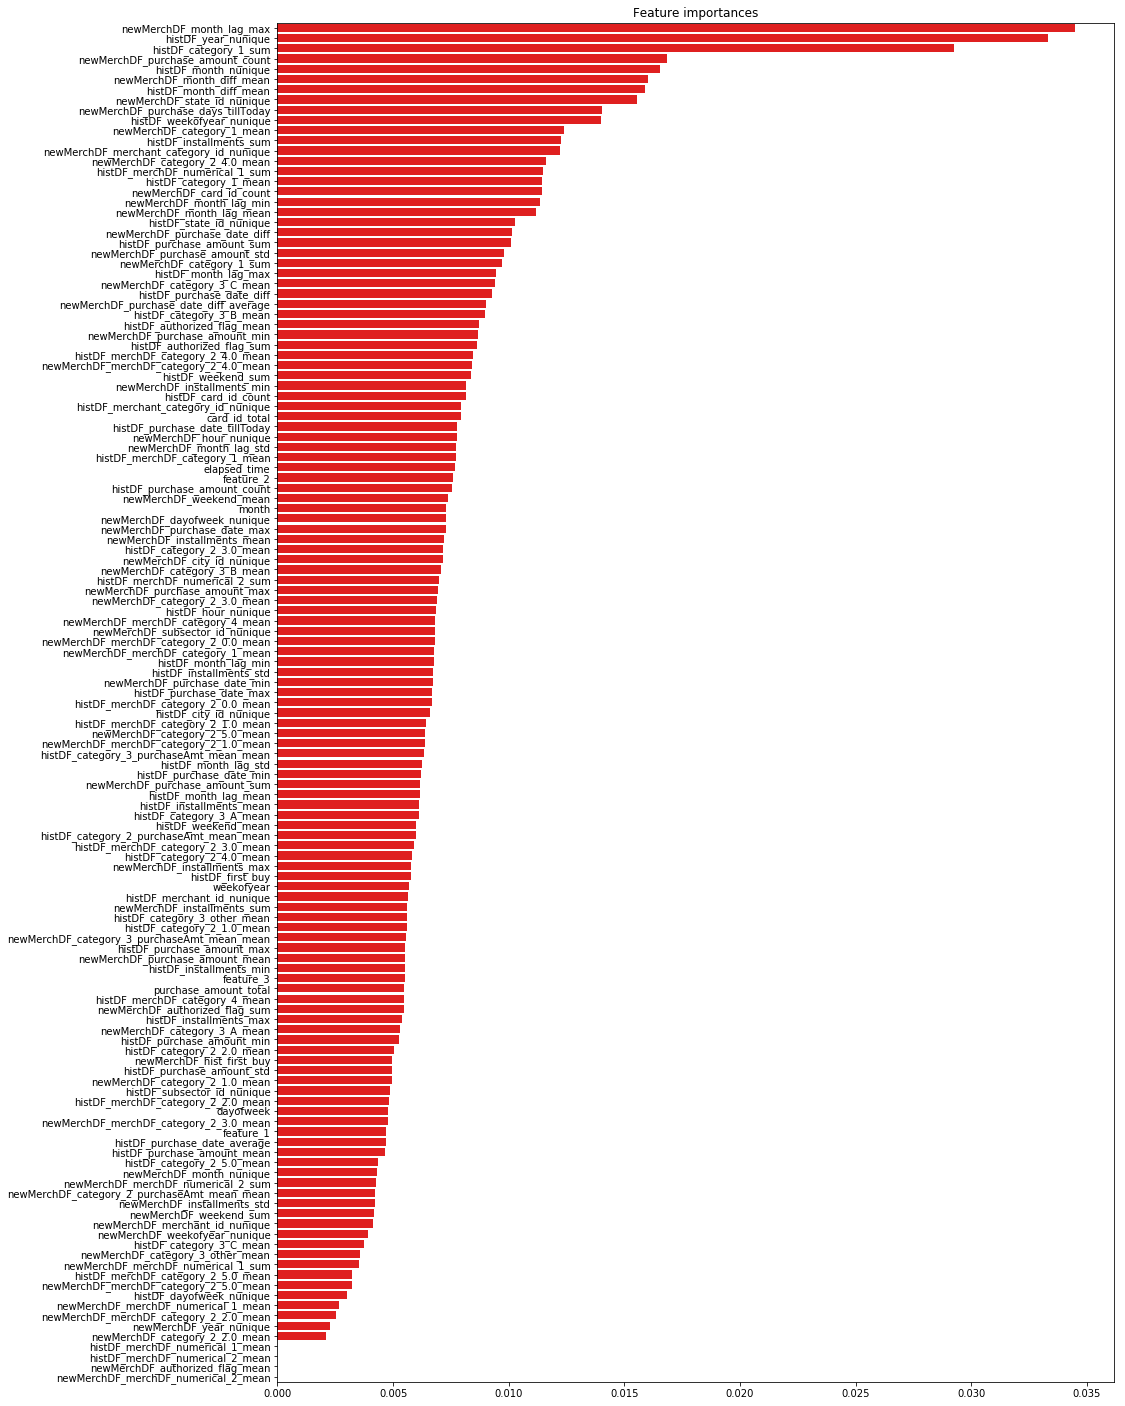

In [101]:
plt.subplots(figsize=(15,25))
plt.title("Feature importances")
ax = sns.barplot(list(featureImp_xgbSortedDict.values()), list(featureImp_xgbSortedDict.keys()), color='r')
plt.show()

In [102]:
predictxg_reg_test = randomSearchCv.predict(testDF[features].values)

In [ ]:
#print("CV score: {:<8.5f}".format(mean_squared_error(target, predictxg_reg_test)**0.5))

In [103]:
subDF = pd.DataFrame({"card_id":testDF["card_id"].values})
subDF["target"] = predictxg_reg_test
subDF.to_csv("submit4.csv", index=False)

## Conclusion

In [210]:
newMerchDF.to_csv("newMerchDF.csv", index=False)